<a href="https://colab.research.google.com/github/jayant2014/MNIST-GAN/blob/master/GAN_Fashion_MNIST_1000_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

##GAN Class

In [0]:
# GAN Class
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(2048))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            #  Train Discriminator

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()


##Run 10000 epochs

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.667146, acc.: 40.62%] [G loss: 0.670328]


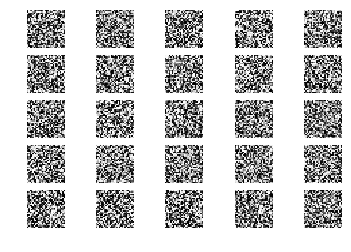

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.442026, acc.: 67.19%] [G loss: 0.742389]
2 [D loss: 0.405587, acc.: 75.00%] [G loss: 0.819537]
3 [D loss: 0.327333, acc.: 87.50%] [G loss: 0.975978]
4 [D loss: 0.279327, acc.: 95.31%] [G loss: 1.110606]
5 [D loss: 0.263943, acc.: 89.06%] [G loss: 1.248234]
6 [D loss: 0.210337, acc.: 100.00%] [G loss: 1.257524]
7 [D loss: 0.218210, acc.: 100.00%] [G loss: 1.464749]
8 [D loss: 0.221474, acc.: 95.31%] [G loss: 1.522927]
9 [D loss: 0.161154, acc.: 100.00%] [G loss: 1.554916]
10 [D loss: 0.199994, acc.: 98.44%] [G loss: 1.785003]
11 [D loss: 0.127772, acc.: 100.00%] [G loss: 1.789364]
12 [D loss: 0.133948, acc.: 100.00%] [G loss: 1.882752]
13 [D loss: 0.104217, acc.: 100.00%] [G loss: 2.014754]
14 [D loss: 0.106599, acc.: 100.00%] [G loss: 2.218548]
15 [D loss: 0.103721, acc.: 100.00%] [G loss: 2.354006]
16 [D loss: 0.085476, acc.: 98.44%] [G loss: 2.340568]
17 [D loss: 0.071316, acc.: 100.00%] [G loss: 2.364963]
18 [D loss: 0.073263, acc.: 100.00%] [G loss: 2.497787]
19 [D los

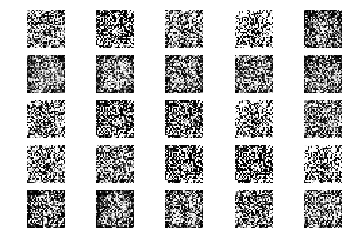

101 [D loss: 0.118526, acc.: 93.75%] [G loss: 4.465049]
102 [D loss: 0.130818, acc.: 95.31%] [G loss: 4.924860]
103 [D loss: 0.162289, acc.: 93.75%] [G loss: 4.732935]
104 [D loss: 0.187839, acc.: 90.62%] [G loss: 5.275387]
105 [D loss: 0.269224, acc.: 90.62%] [G loss: 4.564086]
106 [D loss: 0.200585, acc.: 95.31%] [G loss: 5.126152]
107 [D loss: 0.394375, acc.: 84.38%] [G loss: 5.546591]
108 [D loss: 0.779787, acc.: 62.50%] [G loss: 4.351977]
109 [D loss: 0.160576, acc.: 93.75%] [G loss: 5.556401]
110 [D loss: 0.231753, acc.: 92.19%] [G loss: 4.385985]
111 [D loss: 0.141766, acc.: 93.75%] [G loss: 4.053496]
112 [D loss: 0.120781, acc.: 96.88%] [G loss: 4.934854]
113 [D loss: 0.314662, acc.: 81.25%] [G loss: 4.387794]
114 [D loss: 0.162368, acc.: 95.31%] [G loss: 3.731902]
115 [D loss: 0.244264, acc.: 87.50%] [G loss: 4.001650]
116 [D loss: 0.178570, acc.: 90.62%] [G loss: 4.434963]
117 [D loss: 0.338201, acc.: 85.94%] [G loss: 3.637154]
118 [D loss: 0.220201, acc.: 87.50%] [G loss: 4.

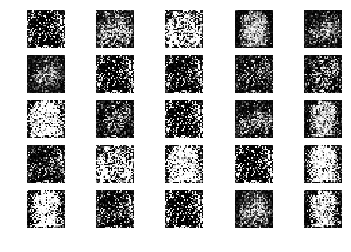

201 [D loss: 0.660736, acc.: 65.62%] [G loss: 3.244774]
202 [D loss: 0.196781, acc.: 92.19%] [G loss: 4.454547]
203 [D loss: 0.433886, acc.: 82.81%] [G loss: 3.534522]
204 [D loss: 0.179046, acc.: 92.19%] [G loss: 4.083195]
205 [D loss: 0.233043, acc.: 90.62%] [G loss: 4.451734]
206 [D loss: 0.324350, acc.: 82.81%] [G loss: 3.777572]
207 [D loss: 0.295164, acc.: 87.50%] [G loss: 3.969250]
208 [D loss: 0.176734, acc.: 95.31%] [G loss: 3.542535]
209 [D loss: 0.291961, acc.: 89.06%] [G loss: 3.481967]
210 [D loss: 0.330331, acc.: 87.50%] [G loss: 3.725447]
211 [D loss: 0.360011, acc.: 85.94%] [G loss: 2.720261]
212 [D loss: 0.329340, acc.: 84.38%] [G loss: 3.912174]
213 [D loss: 0.249420, acc.: 87.50%] [G loss: 2.979854]
214 [D loss: 0.426845, acc.: 79.69%] [G loss: 4.540796]
215 [D loss: 0.331903, acc.: 84.38%] [G loss: 4.989408]
216 [D loss: 0.365130, acc.: 76.56%] [G loss: 3.951035]
217 [D loss: 0.190401, acc.: 93.75%] [G loss: 3.723398]
218 [D loss: 0.160758, acc.: 96.88%] [G loss: 3.

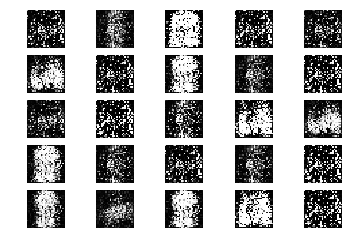

301 [D loss: 0.446470, acc.: 79.69%] [G loss: 2.701502]
302 [D loss: 0.448720, acc.: 78.12%] [G loss: 4.082224]
303 [D loss: 0.645590, acc.: 79.69%] [G loss: 2.869026]
304 [D loss: 0.487316, acc.: 75.00%] [G loss: 3.445537]
305 [D loss: 0.259158, acc.: 87.50%] [G loss: 3.581166]
306 [D loss: 0.442614, acc.: 76.56%] [G loss: 2.461037]
307 [D loss: 0.456185, acc.: 70.31%] [G loss: 3.926450]
308 [D loss: 0.561521, acc.: 70.31%] [G loss: 4.656554]
309 [D loss: 0.395564, acc.: 85.94%] [G loss: 3.995465]
310 [D loss: 0.247220, acc.: 95.31%] [G loss: 3.207265]
311 [D loss: 0.384538, acc.: 84.38%] [G loss: 3.299200]
312 [D loss: 0.376456, acc.: 81.25%] [G loss: 3.022687]
313 [D loss: 0.315315, acc.: 89.06%] [G loss: 3.732827]
314 [D loss: 0.371911, acc.: 90.62%] [G loss: 3.192512]
315 [D loss: 0.343822, acc.: 89.06%] [G loss: 3.176748]
316 [D loss: 0.458789, acc.: 78.12%] [G loss: 3.030655]
317 [D loss: 0.464112, acc.: 79.69%] [G loss: 3.526855]
318 [D loss: 0.329119, acc.: 92.19%] [G loss: 3.

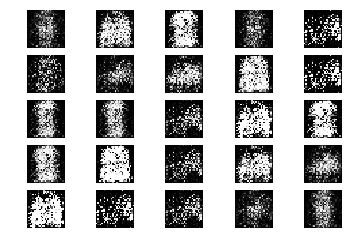

401 [D loss: 0.569769, acc.: 71.88%] [G loss: 2.581239]
402 [D loss: 0.575809, acc.: 67.19%] [G loss: 2.504727]
403 [D loss: 0.462003, acc.: 76.56%] [G loss: 2.580013]
404 [D loss: 0.537067, acc.: 67.19%] [G loss: 2.757336]
405 [D loss: 0.683300, acc.: 60.94%] [G loss: 2.443959]
406 [D loss: 0.517569, acc.: 76.56%] [G loss: 2.706597]
407 [D loss: 0.388668, acc.: 85.94%] [G loss: 2.813642]
408 [D loss: 0.559935, acc.: 62.50%] [G loss: 2.271420]
409 [D loss: 0.480866, acc.: 81.25%] [G loss: 2.585853]
410 [D loss: 0.472079, acc.: 79.69%] [G loss: 2.246256]
411 [D loss: 0.720300, acc.: 64.06%] [G loss: 2.809522]
412 [D loss: 0.564773, acc.: 79.69%] [G loss: 2.428926]
413 [D loss: 0.577536, acc.: 64.06%] [G loss: 1.994003]
414 [D loss: 0.483369, acc.: 81.25%] [G loss: 2.812809]
415 [D loss: 0.419432, acc.: 89.06%] [G loss: 2.949583]
416 [D loss: 0.501315, acc.: 81.25%] [G loss: 2.377279]
417 [D loss: 0.562596, acc.: 79.69%] [G loss: 2.605099]
418 [D loss: 0.406192, acc.: 82.81%] [G loss: 2.

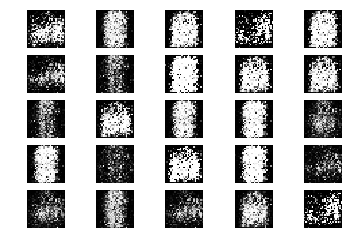

501 [D loss: 0.508190, acc.: 81.25%] [G loss: 2.088556]
502 [D loss: 0.616457, acc.: 73.44%] [G loss: 2.480101]
503 [D loss: 0.604774, acc.: 75.00%] [G loss: 2.087219]
504 [D loss: 0.563193, acc.: 76.56%] [G loss: 2.165083]
505 [D loss: 0.431254, acc.: 82.81%] [G loss: 2.199782]
506 [D loss: 0.454344, acc.: 79.69%] [G loss: 1.963724]
507 [D loss: 0.590411, acc.: 84.38%] [G loss: 2.265867]
508 [D loss: 0.782765, acc.: 51.56%] [G loss: 1.916410]
509 [D loss: 0.569403, acc.: 68.75%] [G loss: 2.085663]
510 [D loss: 0.479191, acc.: 84.38%] [G loss: 2.076200]
511 [D loss: 0.533881, acc.: 67.19%] [G loss: 2.027553]
512 [D loss: 0.525893, acc.: 78.12%] [G loss: 1.710871]
513 [D loss: 0.582633, acc.: 76.56%] [G loss: 2.202333]
514 [D loss: 0.708328, acc.: 59.38%] [G loss: 1.972094]
515 [D loss: 0.657999, acc.: 75.00%] [G loss: 1.748167]
516 [D loss: 0.571981, acc.: 78.12%] [G loss: 1.851418]
517 [D loss: 0.483924, acc.: 82.81%] [G loss: 1.799235]
518 [D loss: 0.472006, acc.: 75.00%] [G loss: 2.

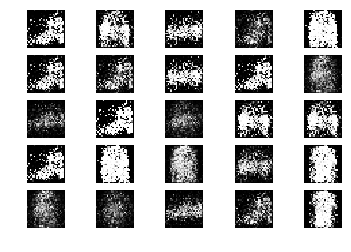

601 [D loss: 0.634825, acc.: 65.62%] [G loss: 1.560442]
602 [D loss: 0.488751, acc.: 78.12%] [G loss: 1.761691]
603 [D loss: 0.668100, acc.: 67.19%] [G loss: 1.672356]
604 [D loss: 0.464860, acc.: 84.38%] [G loss: 1.743509]
605 [D loss: 0.634501, acc.: 67.19%] [G loss: 1.474267]
606 [D loss: 0.685344, acc.: 62.50%] [G loss: 1.547024]
607 [D loss: 0.727228, acc.: 50.00%] [G loss: 1.595071]
608 [D loss: 0.672588, acc.: 65.62%] [G loss: 1.711640]
609 [D loss: 0.573554, acc.: 68.75%] [G loss: 1.566630]
610 [D loss: 0.521009, acc.: 65.62%] [G loss: 1.550361]
611 [D loss: 0.638247, acc.: 67.19%] [G loss: 1.727846]
612 [D loss: 0.600277, acc.: 78.12%] [G loss: 1.556424]
613 [D loss: 0.503928, acc.: 75.00%] [G loss: 1.824795]
614 [D loss: 0.553703, acc.: 70.31%] [G loss: 1.574450]
615 [D loss: 0.624890, acc.: 65.62%] [G loss: 1.619120]
616 [D loss: 0.570307, acc.: 75.00%] [G loss: 1.709106]
617 [D loss: 0.532170, acc.: 75.00%] [G loss: 1.410612]
618 [D loss: 0.574953, acc.: 76.56%] [G loss: 1.

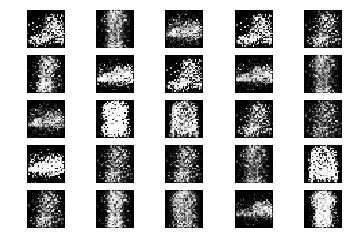

701 [D loss: 0.607095, acc.: 68.75%] [G loss: 1.301743]
702 [D loss: 0.725946, acc.: 53.12%] [G loss: 1.294338]
703 [D loss: 0.659365, acc.: 62.50%] [G loss: 1.232557]
704 [D loss: 0.666291, acc.: 62.50%] [G loss: 1.121253]
705 [D loss: 0.755211, acc.: 42.19%] [G loss: 1.270844]
706 [D loss: 0.787287, acc.: 46.88%] [G loss: 1.158696]
707 [D loss: 0.724351, acc.: 46.88%] [G loss: 1.206165]
708 [D loss: 0.672575, acc.: 50.00%] [G loss: 1.282940]
709 [D loss: 0.723980, acc.: 56.25%] [G loss: 1.096028]
710 [D loss: 0.730562, acc.: 46.88%] [G loss: 1.115169]
711 [D loss: 0.754322, acc.: 46.88%] [G loss: 1.132084]
712 [D loss: 0.718376, acc.: 53.12%] [G loss: 1.101094]
713 [D loss: 0.740060, acc.: 45.31%] [G loss: 1.080020]
714 [D loss: 0.717919, acc.: 51.56%] [G loss: 1.203779]
715 [D loss: 0.721531, acc.: 57.81%] [G loss: 0.983172]
716 [D loss: 0.674024, acc.: 51.56%] [G loss: 1.032486]
717 [D loss: 0.654882, acc.: 59.38%] [G loss: 1.220877]
718 [D loss: 0.802770, acc.: 46.88%] [G loss: 1.

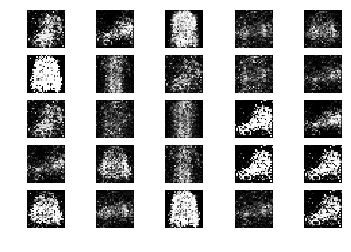

801 [D loss: 0.631948, acc.: 64.06%] [G loss: 0.965151]
802 [D loss: 0.682118, acc.: 54.69%] [G loss: 1.062077]
803 [D loss: 0.674907, acc.: 54.69%] [G loss: 1.053873]
804 [D loss: 0.743246, acc.: 42.19%] [G loss: 0.923418]
805 [D loss: 0.688582, acc.: 57.81%] [G loss: 0.887622]
806 [D loss: 0.744595, acc.: 46.88%] [G loss: 0.927850]
807 [D loss: 0.759572, acc.: 54.69%] [G loss: 0.974484]
808 [D loss: 0.655832, acc.: 59.38%] [G loss: 0.960714]
809 [D loss: 0.608820, acc.: 62.50%] [G loss: 1.027112]
810 [D loss: 0.619956, acc.: 59.38%] [G loss: 0.955106]
811 [D loss: 0.761252, acc.: 50.00%] [G loss: 0.957896]
812 [D loss: 0.644464, acc.: 60.94%] [G loss: 1.027726]
813 [D loss: 0.683729, acc.: 59.38%] [G loss: 1.121677]
814 [D loss: 0.762895, acc.: 48.44%] [G loss: 0.903872]
815 [D loss: 0.740705, acc.: 48.44%] [G loss: 0.970389]
816 [D loss: 0.702575, acc.: 51.56%] [G loss: 1.009460]
817 [D loss: 0.701307, acc.: 56.25%] [G loss: 1.019818]
818 [D loss: 0.664698, acc.: 57.81%] [G loss: 1.

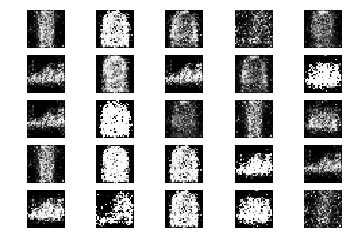

901 [D loss: 0.658233, acc.: 65.62%] [G loss: 0.962060]
902 [D loss: 0.600479, acc.: 78.12%] [G loss: 0.996612]
903 [D loss: 0.678067, acc.: 53.12%] [G loss: 1.066471]
904 [D loss: 0.714701, acc.: 56.25%] [G loss: 0.978799]
905 [D loss: 0.689851, acc.: 53.12%] [G loss: 0.951263]
906 [D loss: 0.660984, acc.: 56.25%] [G loss: 0.838360]
907 [D loss: 0.636047, acc.: 62.50%] [G loss: 0.995535]
908 [D loss: 0.710217, acc.: 53.12%] [G loss: 0.983000]
909 [D loss: 0.684193, acc.: 51.56%] [G loss: 0.930172]
910 [D loss: 0.699739, acc.: 59.38%] [G loss: 0.984354]
911 [D loss: 0.753415, acc.: 50.00%] [G loss: 0.993276]
912 [D loss: 0.675681, acc.: 56.25%] [G loss: 0.887712]
913 [D loss: 0.629044, acc.: 62.50%] [G loss: 0.997253]
914 [D loss: 0.677021, acc.: 56.25%] [G loss: 0.974415]
915 [D loss: 0.725175, acc.: 45.31%] [G loss: 0.908312]
916 [D loss: 0.718093, acc.: 46.88%] [G loss: 0.875462]
917 [D loss: 0.689009, acc.: 54.69%] [G loss: 0.950320]
918 [D loss: 0.686232, acc.: 57.81%] [G loss: 0.

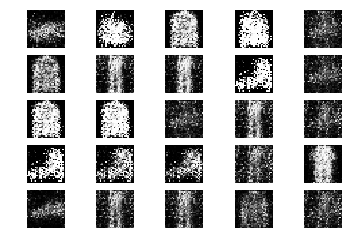

1001 [D loss: 0.655399, acc.: 59.38%] [G loss: 0.892471]
1002 [D loss: 0.663841, acc.: 54.69%] [G loss: 1.006853]
1003 [D loss: 0.653693, acc.: 57.81%] [G loss: 0.953324]
1004 [D loss: 0.619995, acc.: 67.19%] [G loss: 0.961372]
1005 [D loss: 0.657225, acc.: 54.69%] [G loss: 0.883000]
1006 [D loss: 0.630702, acc.: 68.75%] [G loss: 0.966296]
1007 [D loss: 0.743201, acc.: 54.69%] [G loss: 0.824599]
1008 [D loss: 0.704711, acc.: 51.56%] [G loss: 0.767655]
1009 [D loss: 0.714747, acc.: 54.69%] [G loss: 0.802900]
1010 [D loss: 0.682769, acc.: 54.69%] [G loss: 0.795763]
1011 [D loss: 0.715370, acc.: 57.81%] [G loss: 0.818552]
1012 [D loss: 0.614218, acc.: 64.06%] [G loss: 0.869418]
1013 [D loss: 0.609574, acc.: 73.44%] [G loss: 0.928293]
1014 [D loss: 0.769580, acc.: 50.00%] [G loss: 0.999565]
1015 [D loss: 0.657041, acc.: 64.06%] [G loss: 1.005021]
1016 [D loss: 0.638238, acc.: 62.50%] [G loss: 0.916582]
1017 [D loss: 0.810525, acc.: 37.50%] [G loss: 0.864482]
1018 [D loss: 0.674876, acc.: 4

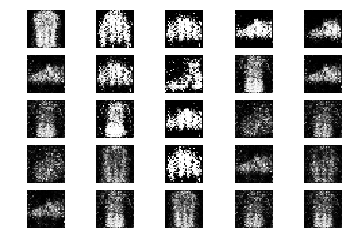

1101 [D loss: 0.650145, acc.: 60.94%] [G loss: 0.930801]
1102 [D loss: 0.673771, acc.: 62.50%] [G loss: 1.002773]
1103 [D loss: 0.638874, acc.: 62.50%] [G loss: 0.934739]
1104 [D loss: 0.648989, acc.: 62.50%] [G loss: 0.917119]
1105 [D loss: 0.612232, acc.: 70.31%] [G loss: 1.089258]
1106 [D loss: 0.700674, acc.: 62.50%] [G loss: 0.924486]
1107 [D loss: 0.720378, acc.: 56.25%] [G loss: 0.879270]
1108 [D loss: 0.648086, acc.: 56.25%] [G loss: 0.924527]
1109 [D loss: 0.610452, acc.: 71.88%] [G loss: 0.932064]
1110 [D loss: 0.712152, acc.: 50.00%] [G loss: 0.925706]
1111 [D loss: 0.691279, acc.: 62.50%] [G loss: 0.935164]
1112 [D loss: 0.631264, acc.: 65.62%] [G loss: 0.935206]
1113 [D loss: 0.594273, acc.: 67.19%] [G loss: 0.964687]
1114 [D loss: 0.598378, acc.: 64.06%] [G loss: 0.944832]
1115 [D loss: 0.644589, acc.: 62.50%] [G loss: 1.009995]
1116 [D loss: 0.605434, acc.: 70.31%] [G loss: 1.021235]
1117 [D loss: 0.585162, acc.: 65.62%] [G loss: 1.040182]
1118 [D loss: 0.635762, acc.: 6

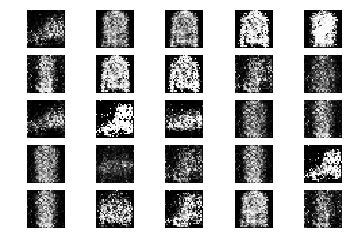

1201 [D loss: 0.744848, acc.: 48.44%] [G loss: 0.866616]
1202 [D loss: 0.664065, acc.: 50.00%] [G loss: 0.880434]
1203 [D loss: 0.687779, acc.: 50.00%] [G loss: 0.830580]
1204 [D loss: 0.723470, acc.: 48.44%] [G loss: 0.803491]
1205 [D loss: 0.673122, acc.: 48.44%] [G loss: 0.833398]
1206 [D loss: 0.673953, acc.: 56.25%] [G loss: 0.847690]
1207 [D loss: 0.674042, acc.: 57.81%] [G loss: 0.863847]
1208 [D loss: 0.640785, acc.: 60.94%] [G loss: 0.859271]
1209 [D loss: 0.665847, acc.: 57.81%] [G loss: 0.918300]
1210 [D loss: 0.664592, acc.: 60.94%] [G loss: 0.939212]
1211 [D loss: 0.656486, acc.: 62.50%] [G loss: 0.904650]
1212 [D loss: 0.645018, acc.: 57.81%] [G loss: 0.921344]
1213 [D loss: 0.703950, acc.: 53.12%] [G loss: 0.846020]
1214 [D loss: 0.624812, acc.: 60.94%] [G loss: 0.853480]
1215 [D loss: 0.699068, acc.: 53.12%] [G loss: 0.916477]
1216 [D loss: 0.740460, acc.: 39.06%] [G loss: 0.902992]
1217 [D loss: 0.677670, acc.: 53.12%] [G loss: 0.899449]
1218 [D loss: 0.779709, acc.: 3

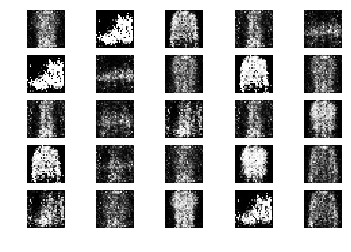

1301 [D loss: 0.686211, acc.: 51.56%] [G loss: 0.765723]
1302 [D loss: 0.637902, acc.: 67.19%] [G loss: 0.830193]
1303 [D loss: 0.672244, acc.: 65.62%] [G loss: 0.772822]
1304 [D loss: 0.673495, acc.: 53.12%] [G loss: 0.840005]
1305 [D loss: 0.755561, acc.: 34.38%] [G loss: 0.877236]
1306 [D loss: 0.710277, acc.: 42.19%] [G loss: 0.864473]
1307 [D loss: 0.762839, acc.: 43.75%] [G loss: 0.854977]
1308 [D loss: 0.668418, acc.: 64.06%] [G loss: 0.916232]
1309 [D loss: 0.638173, acc.: 54.69%] [G loss: 0.963298]
1310 [D loss: 0.652118, acc.: 59.38%] [G loss: 1.000299]
1311 [D loss: 0.726119, acc.: 46.88%] [G loss: 0.866918]
1312 [D loss: 0.621215, acc.: 60.94%] [G loss: 0.931202]
1313 [D loss: 0.649397, acc.: 64.06%] [G loss: 0.897829]
1314 [D loss: 0.708384, acc.: 45.31%] [G loss: 0.841497]
1315 [D loss: 0.709193, acc.: 43.75%] [G loss: 0.849674]
1316 [D loss: 0.634673, acc.: 56.25%] [G loss: 0.972300]
1317 [D loss: 0.698380, acc.: 43.75%] [G loss: 0.976406]
1318 [D loss: 0.690546, acc.: 5

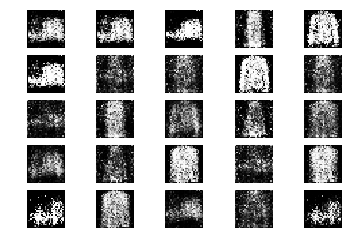

1401 [D loss: 0.673463, acc.: 54.69%] [G loss: 0.893641]
1402 [D loss: 0.675124, acc.: 51.56%] [G loss: 0.857803]
1403 [D loss: 0.657571, acc.: 59.38%] [G loss: 0.907910]
1404 [D loss: 0.651749, acc.: 62.50%] [G loss: 0.853507]
1405 [D loss: 0.640487, acc.: 57.81%] [G loss: 0.923864]
1406 [D loss: 0.608190, acc.: 68.75%] [G loss: 0.890037]
1407 [D loss: 0.645345, acc.: 60.94%] [G loss: 0.914362]
1408 [D loss: 0.716888, acc.: 48.44%] [G loss: 0.860113]
1409 [D loss: 0.677426, acc.: 51.56%] [G loss: 0.891546]
1410 [D loss: 0.628279, acc.: 62.50%] [G loss: 0.896407]
1411 [D loss: 0.633817, acc.: 67.19%] [G loss: 0.845909]
1412 [D loss: 0.641893, acc.: 48.44%] [G loss: 0.878051]
1413 [D loss: 0.661789, acc.: 57.81%] [G loss: 0.853118]
1414 [D loss: 0.659131, acc.: 57.81%] [G loss: 0.800237]
1415 [D loss: 0.617805, acc.: 65.62%] [G loss: 0.829216]
1416 [D loss: 0.700517, acc.: 53.12%] [G loss: 0.854177]
1417 [D loss: 0.663873, acc.: 57.81%] [G loss: 0.846493]
1418 [D loss: 0.705205, acc.: 5

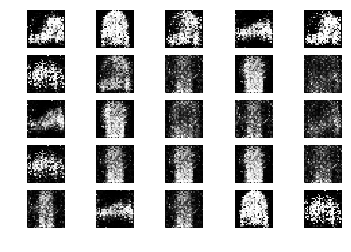

1501 [D loss: 0.563076, acc.: 73.44%] [G loss: 0.934800]
1502 [D loss: 0.723181, acc.: 46.88%] [G loss: 0.924114]
1503 [D loss: 0.632431, acc.: 54.69%] [G loss: 0.843027]
1504 [D loss: 0.638564, acc.: 62.50%] [G loss: 0.853333]
1505 [D loss: 0.657728, acc.: 50.00%] [G loss: 0.952392]
1506 [D loss: 0.676364, acc.: 56.25%] [G loss: 0.848460]
1507 [D loss: 0.658616, acc.: 53.12%] [G loss: 0.877950]
1508 [D loss: 0.638840, acc.: 64.06%] [G loss: 1.005468]
1509 [D loss: 0.605026, acc.: 73.44%] [G loss: 0.985505]
1510 [D loss: 0.621109, acc.: 62.50%] [G loss: 0.987199]
1511 [D loss: 0.647375, acc.: 56.25%] [G loss: 0.900851]
1512 [D loss: 0.653663, acc.: 65.62%] [G loss: 0.864382]
1513 [D loss: 0.604192, acc.: 71.88%] [G loss: 0.826556]
1514 [D loss: 0.623355, acc.: 59.38%] [G loss: 0.911658]
1515 [D loss: 0.618079, acc.: 59.38%] [G loss: 1.014149]
1516 [D loss: 0.676094, acc.: 54.69%] [G loss: 0.946473]
1517 [D loss: 0.622737, acc.: 65.62%] [G loss: 0.891167]
1518 [D loss: 0.592970, acc.: 6

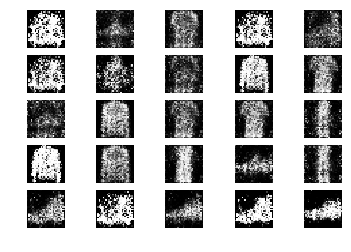

1601 [D loss: 0.618063, acc.: 64.06%] [G loss: 0.918352]
1602 [D loss: 0.615411, acc.: 65.62%] [G loss: 0.903227]
1603 [D loss: 0.679845, acc.: 46.88%] [G loss: 0.871152]
1604 [D loss: 0.629553, acc.: 60.94%] [G loss: 0.899890]
1605 [D loss: 0.634788, acc.: 60.94%] [G loss: 0.931577]
1606 [D loss: 0.648476, acc.: 60.94%] [G loss: 0.910336]
1607 [D loss: 0.626080, acc.: 56.25%] [G loss: 0.900943]
1608 [D loss: 0.681832, acc.: 54.69%] [G loss: 0.874524]
1609 [D loss: 0.605134, acc.: 65.62%] [G loss: 0.870950]
1610 [D loss: 0.632485, acc.: 57.81%] [G loss: 0.887092]
1611 [D loss: 0.616144, acc.: 62.50%] [G loss: 0.953252]
1612 [D loss: 0.626463, acc.: 64.06%] [G loss: 0.889390]
1613 [D loss: 0.629622, acc.: 57.81%] [G loss: 0.882181]
1614 [D loss: 0.592870, acc.: 71.88%] [G loss: 0.901303]
1615 [D loss: 0.568151, acc.: 67.19%] [G loss: 0.933213]
1616 [D loss: 0.593904, acc.: 64.06%] [G loss: 0.973568]
1617 [D loss: 0.600376, acc.: 68.75%] [G loss: 0.932267]
1618 [D loss: 0.639432, acc.: 6

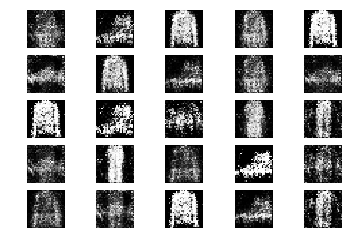

1701 [D loss: 0.747362, acc.: 37.50%] [G loss: 0.981737]
1702 [D loss: 0.668838, acc.: 54.69%] [G loss: 0.915260]
1703 [D loss: 0.688334, acc.: 53.12%] [G loss: 0.952925]
1704 [D loss: 0.705069, acc.: 53.12%] [G loss: 0.858323]
1705 [D loss: 0.578231, acc.: 70.31%] [G loss: 0.949367]
1706 [D loss: 0.639085, acc.: 62.50%] [G loss: 0.919862]
1707 [D loss: 0.684102, acc.: 54.69%] [G loss: 0.857206]
1708 [D loss: 0.715153, acc.: 43.75%] [G loss: 0.809117]
1709 [D loss: 0.628229, acc.: 65.62%] [G loss: 0.932597]
1710 [D loss: 0.634464, acc.: 53.12%] [G loss: 0.924105]
1711 [D loss: 0.660962, acc.: 64.06%] [G loss: 0.866400]
1712 [D loss: 0.622015, acc.: 65.62%] [G loss: 0.987667]
1713 [D loss: 0.639627, acc.: 59.38%] [G loss: 0.979414]
1714 [D loss: 0.700373, acc.: 57.81%] [G loss: 1.053653]
1715 [D loss: 0.601285, acc.: 70.31%] [G loss: 1.030775]
1716 [D loss: 0.617289, acc.: 73.44%] [G loss: 1.079954]
1717 [D loss: 0.618125, acc.: 65.62%] [G loss: 0.992209]
1718 [D loss: 0.693822, acc.: 4

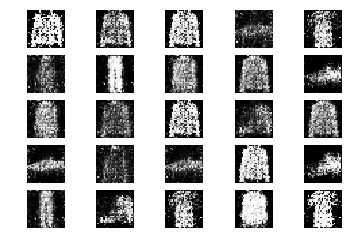

1801 [D loss: 0.684623, acc.: 51.56%] [G loss: 0.878002]
1802 [D loss: 0.656407, acc.: 59.38%] [G loss: 0.900709]
1803 [D loss: 0.666845, acc.: 56.25%] [G loss: 0.877416]
1804 [D loss: 0.649348, acc.: 57.81%] [G loss: 0.951323]
1805 [D loss: 0.698536, acc.: 50.00%] [G loss: 0.983389]
1806 [D loss: 0.638920, acc.: 60.94%] [G loss: 0.898799]
1807 [D loss: 0.635843, acc.: 60.94%] [G loss: 0.841185]
1808 [D loss: 0.716889, acc.: 51.56%] [G loss: 0.833864]
1809 [D loss: 0.685727, acc.: 53.12%] [G loss: 0.818332]
1810 [D loss: 0.702913, acc.: 53.12%] [G loss: 0.872041]
1811 [D loss: 0.657809, acc.: 59.38%] [G loss: 0.866573]
1812 [D loss: 0.681001, acc.: 56.25%] [G loss: 0.928037]
1813 [D loss: 0.672332, acc.: 57.81%] [G loss: 0.927645]
1814 [D loss: 0.658217, acc.: 56.25%] [G loss: 0.889571]
1815 [D loss: 0.626433, acc.: 64.06%] [G loss: 0.839689]
1816 [D loss: 0.740883, acc.: 46.88%] [G loss: 0.927481]
1817 [D loss: 0.671236, acc.: 60.94%] [G loss: 0.923534]
1818 [D loss: 0.714594, acc.: 4

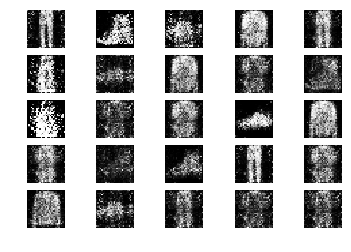

1901 [D loss: 0.677316, acc.: 57.81%] [G loss: 0.944654]
1902 [D loss: 0.663786, acc.: 62.50%] [G loss: 0.869677]
1903 [D loss: 0.666286, acc.: 56.25%] [G loss: 0.976669]
1904 [D loss: 0.638879, acc.: 57.81%] [G loss: 0.886861]
1905 [D loss: 0.627482, acc.: 65.62%] [G loss: 0.871230]
1906 [D loss: 0.691275, acc.: 50.00%] [G loss: 0.911243]
1907 [D loss: 0.642314, acc.: 53.12%] [G loss: 0.829843]
1908 [D loss: 0.649816, acc.: 56.25%] [G loss: 0.846939]
1909 [D loss: 0.729415, acc.: 48.44%] [G loss: 0.877047]
1910 [D loss: 0.588280, acc.: 73.44%] [G loss: 0.900016]
1911 [D loss: 0.686743, acc.: 53.12%] [G loss: 0.853147]
1912 [D loss: 0.654333, acc.: 53.12%] [G loss: 0.933885]
1913 [D loss: 0.639033, acc.: 64.06%] [G loss: 0.823372]
1914 [D loss: 0.632659, acc.: 60.94%] [G loss: 0.832729]
1915 [D loss: 0.657511, acc.: 60.94%] [G loss: 0.829280]
1916 [D loss: 0.670629, acc.: 62.50%] [G loss: 0.760933]
1917 [D loss: 0.682442, acc.: 56.25%] [G loss: 0.771222]
1918 [D loss: 0.605168, acc.: 6

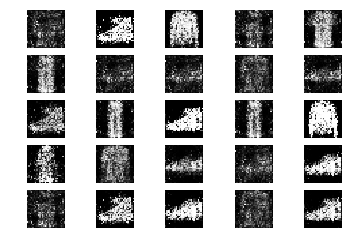

2001 [D loss: 0.574796, acc.: 67.19%] [G loss: 0.910985]
2002 [D loss: 0.731946, acc.: 51.56%] [G loss: 1.005460]
2003 [D loss: 0.694467, acc.: 50.00%] [G loss: 0.852837]
2004 [D loss: 0.615079, acc.: 67.19%] [G loss: 0.918204]
2005 [D loss: 0.665845, acc.: 53.12%] [G loss: 0.893264]
2006 [D loss: 0.620144, acc.: 62.50%] [G loss: 0.924908]
2007 [D loss: 0.655057, acc.: 54.69%] [G loss: 0.908561]
2008 [D loss: 0.595363, acc.: 68.75%] [G loss: 0.966705]
2009 [D loss: 0.640295, acc.: 67.19%] [G loss: 0.897178]
2010 [D loss: 0.691488, acc.: 59.38%] [G loss: 0.891928]
2011 [D loss: 0.620676, acc.: 65.62%] [G loss: 0.933953]
2012 [D loss: 0.651842, acc.: 64.06%] [G loss: 0.981073]
2013 [D loss: 0.682960, acc.: 53.12%] [G loss: 0.963062]
2014 [D loss: 0.682374, acc.: 60.94%] [G loss: 0.835888]
2015 [D loss: 0.565805, acc.: 76.56%] [G loss: 0.960345]
2016 [D loss: 0.629867, acc.: 67.19%] [G loss: 0.904168]
2017 [D loss: 0.659679, acc.: 62.50%] [G loss: 0.840454]
2018 [D loss: 0.711177, acc.: 5

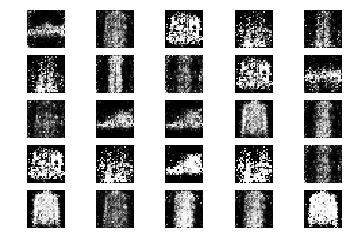

2101 [D loss: 0.730870, acc.: 50.00%] [G loss: 0.931953]
2102 [D loss: 0.624476, acc.: 64.06%] [G loss: 0.944415]
2103 [D loss: 0.638721, acc.: 62.50%] [G loss: 0.925830]
2104 [D loss: 0.593496, acc.: 75.00%] [G loss: 0.938303]
2105 [D loss: 0.570060, acc.: 71.88%] [G loss: 0.953195]
2106 [D loss: 0.603771, acc.: 71.88%] [G loss: 0.936894]
2107 [D loss: 0.612268, acc.: 64.06%] [G loss: 1.014090]
2108 [D loss: 0.563880, acc.: 75.00%] [G loss: 0.983578]
2109 [D loss: 0.652061, acc.: 60.94%] [G loss: 1.070613]
2110 [D loss: 0.665292, acc.: 50.00%] [G loss: 1.003590]
2111 [D loss: 0.676697, acc.: 57.81%] [G loss: 0.978621]
2112 [D loss: 0.604855, acc.: 62.50%] [G loss: 0.973980]
2113 [D loss: 0.650876, acc.: 56.25%] [G loss: 0.925313]
2114 [D loss: 0.641399, acc.: 59.38%] [G loss: 0.949552]
2115 [D loss: 0.646809, acc.: 60.94%] [G loss: 0.886064]
2116 [D loss: 0.632004, acc.: 59.38%] [G loss: 0.976737]
2117 [D loss: 0.551611, acc.: 71.88%] [G loss: 0.970595]
2118 [D loss: 0.646017, acc.: 5

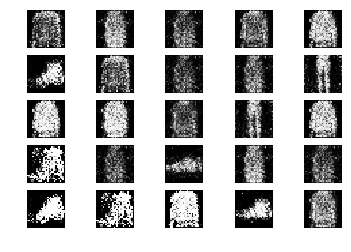

2201 [D loss: 0.652272, acc.: 51.56%] [G loss: 0.912209]
2202 [D loss: 0.615818, acc.: 64.06%] [G loss: 0.856662]
2203 [D loss: 0.679626, acc.: 50.00%] [G loss: 0.862617]
2204 [D loss: 0.608694, acc.: 64.06%] [G loss: 0.925641]
2205 [D loss: 0.650902, acc.: 56.25%] [G loss: 0.844993]
2206 [D loss: 0.624050, acc.: 57.81%] [G loss: 0.982493]
2207 [D loss: 0.596033, acc.: 60.94%] [G loss: 0.993077]
2208 [D loss: 0.707083, acc.: 54.69%] [G loss: 1.000405]
2209 [D loss: 0.567576, acc.: 59.38%] [G loss: 1.027267]
2210 [D loss: 0.597208, acc.: 65.62%] [G loss: 1.001817]
2211 [D loss: 0.696285, acc.: 54.69%] [G loss: 0.919026]
2212 [D loss: 0.577723, acc.: 62.50%] [G loss: 0.873784]
2213 [D loss: 0.601922, acc.: 60.94%] [G loss: 0.972420]
2214 [D loss: 0.609329, acc.: 64.06%] [G loss: 0.891958]
2215 [D loss: 0.587529, acc.: 60.94%] [G loss: 0.929928]
2216 [D loss: 0.606822, acc.: 64.06%] [G loss: 0.874103]
2217 [D loss: 0.591797, acc.: 68.75%] [G loss: 0.912854]
2218 [D loss: 0.644130, acc.: 5

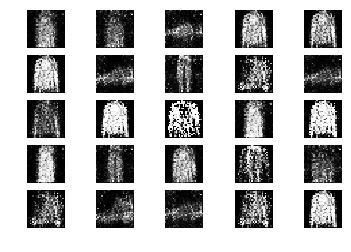

2301 [D loss: 0.632437, acc.: 60.94%] [G loss: 0.944760]
2302 [D loss: 0.548146, acc.: 71.88%] [G loss: 0.972166]
2303 [D loss: 0.671452, acc.: 53.12%] [G loss: 1.047155]
2304 [D loss: 0.622015, acc.: 60.94%] [G loss: 0.986204]
2305 [D loss: 0.633486, acc.: 59.38%] [G loss: 0.968455]
2306 [D loss: 0.673679, acc.: 51.56%] [G loss: 0.996252]
2307 [D loss: 0.589062, acc.: 76.56%] [G loss: 1.064393]
2308 [D loss: 0.632365, acc.: 64.06%] [G loss: 1.028332]
2309 [D loss: 0.571737, acc.: 75.00%] [G loss: 1.077378]
2310 [D loss: 0.663217, acc.: 65.62%] [G loss: 0.894118]
2311 [D loss: 0.553165, acc.: 78.12%] [G loss: 0.965155]
2312 [D loss: 0.602731, acc.: 68.75%] [G loss: 0.935889]
2313 [D loss: 0.609429, acc.: 62.50%] [G loss: 0.995901]
2314 [D loss: 0.694383, acc.: 60.94%] [G loss: 0.848131]
2315 [D loss: 0.652600, acc.: 56.25%] [G loss: 0.870622]
2316 [D loss: 0.667976, acc.: 59.38%] [G loss: 0.935791]
2317 [D loss: 0.606359, acc.: 60.94%] [G loss: 0.879718]
2318 [D loss: 0.671803, acc.: 5

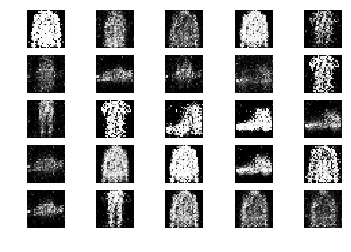

2401 [D loss: 0.678470, acc.: 48.44%] [G loss: 0.928737]
2402 [D loss: 0.623060, acc.: 67.19%] [G loss: 0.860760]
2403 [D loss: 0.616291, acc.: 64.06%] [G loss: 0.823253]
2404 [D loss: 0.654729, acc.: 62.50%] [G loss: 0.860646]
2405 [D loss: 0.666490, acc.: 60.94%] [G loss: 0.953207]
2406 [D loss: 0.616673, acc.: 60.94%] [G loss: 0.926349]
2407 [D loss: 0.578834, acc.: 70.31%] [G loss: 1.039276]
2408 [D loss: 0.590966, acc.: 70.31%] [G loss: 1.022639]
2409 [D loss: 0.704732, acc.: 59.38%] [G loss: 0.968132]
2410 [D loss: 0.615668, acc.: 59.38%] [G loss: 0.864612]
2411 [D loss: 0.730739, acc.: 51.56%] [G loss: 0.868059]
2412 [D loss: 0.609432, acc.: 60.94%] [G loss: 0.931242]
2413 [D loss: 0.608480, acc.: 70.31%] [G loss: 1.016212]
2414 [D loss: 0.630189, acc.: 67.19%] [G loss: 1.019893]
2415 [D loss: 0.569504, acc.: 76.56%] [G loss: 0.979634]
2416 [D loss: 0.698333, acc.: 64.06%] [G loss: 0.942477]
2417 [D loss: 0.757651, acc.: 42.19%] [G loss: 0.840618]
2418 [D loss: 0.661007, acc.: 5

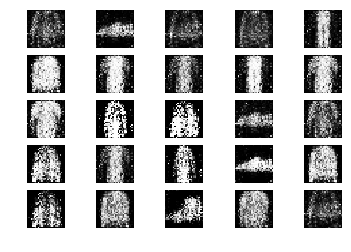

2501 [D loss: 0.651642, acc.: 64.06%] [G loss: 0.907539]
2502 [D loss: 0.646986, acc.: 64.06%] [G loss: 0.889309]
2503 [D loss: 0.666790, acc.: 62.50%] [G loss: 0.870942]
2504 [D loss: 0.625142, acc.: 68.75%] [G loss: 0.906858]
2505 [D loss: 0.633626, acc.: 62.50%] [G loss: 0.886901]
2506 [D loss: 0.695870, acc.: 51.56%] [G loss: 0.940756]
2507 [D loss: 0.671612, acc.: 59.38%] [G loss: 0.929434]
2508 [D loss: 0.622519, acc.: 70.31%] [G loss: 0.921245]
2509 [D loss: 0.621350, acc.: 59.38%] [G loss: 0.977853]
2510 [D loss: 0.706987, acc.: 60.94%] [G loss: 0.924106]
2511 [D loss: 0.671735, acc.: 54.69%] [G loss: 0.949120]
2512 [D loss: 0.610091, acc.: 67.19%] [G loss: 0.970702]
2513 [D loss: 0.680362, acc.: 59.38%] [G loss: 0.969076]
2514 [D loss: 0.686865, acc.: 56.25%] [G loss: 0.920127]
2515 [D loss: 0.502352, acc.: 75.00%] [G loss: 0.968263]
2516 [D loss: 0.659366, acc.: 56.25%] [G loss: 0.975349]
2517 [D loss: 0.575912, acc.: 68.75%] [G loss: 1.035809]
2518 [D loss: 0.616776, acc.: 6

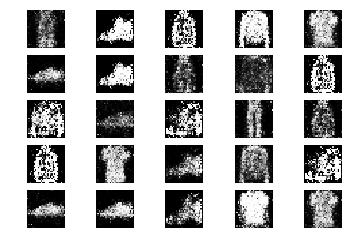

2601 [D loss: 0.666638, acc.: 59.38%] [G loss: 0.915307]
2602 [D loss: 0.684266, acc.: 57.81%] [G loss: 0.945423]
2603 [D loss: 0.623357, acc.: 70.31%] [G loss: 1.054778]
2604 [D loss: 0.609382, acc.: 68.75%] [G loss: 1.009372]
2605 [D loss: 0.587609, acc.: 67.19%] [G loss: 0.950759]
2606 [D loss: 0.559792, acc.: 67.19%] [G loss: 1.128180]
2607 [D loss: 0.726612, acc.: 53.12%] [G loss: 1.102549]
2608 [D loss: 0.635920, acc.: 60.94%] [G loss: 1.087643]
2609 [D loss: 0.625718, acc.: 57.81%] [G loss: 1.180431]
2610 [D loss: 0.612172, acc.: 64.06%] [G loss: 0.982189]
2611 [D loss: 0.578633, acc.: 64.06%] [G loss: 1.111714]
2612 [D loss: 0.704148, acc.: 60.94%] [G loss: 0.967602]
2613 [D loss: 0.686528, acc.: 51.56%] [G loss: 0.971729]
2614 [D loss: 0.653610, acc.: 65.62%] [G loss: 0.969691]
2615 [D loss: 0.640193, acc.: 60.94%] [G loss: 0.996781]
2616 [D loss: 0.613192, acc.: 57.81%] [G loss: 1.045293]
2617 [D loss: 0.678241, acc.: 64.06%] [G loss: 0.993468]
2618 [D loss: 0.609698, acc.: 5

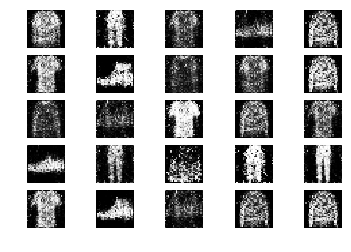

2701 [D loss: 0.652282, acc.: 57.81%] [G loss: 0.883071]
2702 [D loss: 0.623973, acc.: 67.19%] [G loss: 0.890527]
2703 [D loss: 0.638314, acc.: 60.94%] [G loss: 0.967883]
2704 [D loss: 0.631421, acc.: 62.50%] [G loss: 1.011351]
2705 [D loss: 0.625769, acc.: 67.19%] [G loss: 1.023022]
2706 [D loss: 0.565000, acc.: 71.88%] [G loss: 1.023264]
2707 [D loss: 0.576591, acc.: 68.75%] [G loss: 1.020530]
2708 [D loss: 0.708046, acc.: 50.00%] [G loss: 0.906475]
2709 [D loss: 0.649028, acc.: 65.62%] [G loss: 0.925443]
2710 [D loss: 0.743706, acc.: 40.62%] [G loss: 0.918427]
2711 [D loss: 0.627932, acc.: 64.06%] [G loss: 0.943102]
2712 [D loss: 0.709332, acc.: 51.56%] [G loss: 0.913039]
2713 [D loss: 0.615032, acc.: 64.06%] [G loss: 0.949352]
2714 [D loss: 0.694295, acc.: 50.00%] [G loss: 0.896097]
2715 [D loss: 0.588934, acc.: 64.06%] [G loss: 0.989089]
2716 [D loss: 0.719341, acc.: 48.44%] [G loss: 0.948381]
2717 [D loss: 0.624627, acc.: 67.19%] [G loss: 0.861636]
2718 [D loss: 0.622685, acc.: 5

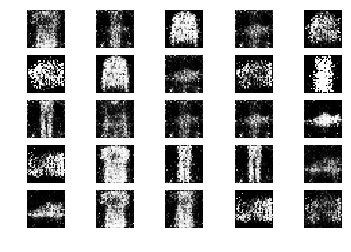

2801 [D loss: 0.550854, acc.: 79.69%] [G loss: 1.100031]
2802 [D loss: 0.583891, acc.: 68.75%] [G loss: 1.042296]
2803 [D loss: 0.630328, acc.: 65.62%] [G loss: 0.943566]
2804 [D loss: 0.612014, acc.: 64.06%] [G loss: 0.972132]
2805 [D loss: 0.535444, acc.: 70.31%] [G loss: 1.037121]
2806 [D loss: 0.592884, acc.: 68.75%] [G loss: 1.028642]
2807 [D loss: 0.549994, acc.: 73.44%] [G loss: 1.092266]
2808 [D loss: 0.553825, acc.: 73.44%] [G loss: 1.092328]
2809 [D loss: 0.587426, acc.: 78.12%] [G loss: 1.047227]
2810 [D loss: 0.616579, acc.: 73.44%] [G loss: 1.019115]
2811 [D loss: 0.604379, acc.: 65.62%] [G loss: 0.911990]
2812 [D loss: 0.601897, acc.: 71.88%] [G loss: 0.981904]
2813 [D loss: 0.579218, acc.: 70.31%] [G loss: 1.049742]
2814 [D loss: 0.629919, acc.: 60.94%] [G loss: 1.053593]
2815 [D loss: 0.593114, acc.: 70.31%] [G loss: 0.996508]
2816 [D loss: 0.629688, acc.: 65.62%] [G loss: 0.956667]
2817 [D loss: 0.698367, acc.: 51.56%] [G loss: 0.889010]
2818 [D loss: 0.654783, acc.: 5

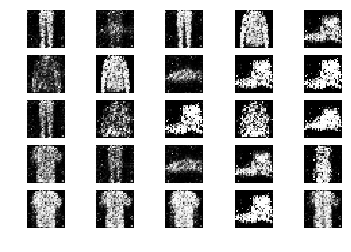

2901 [D loss: 0.667212, acc.: 56.25%] [G loss: 0.892118]
2902 [D loss: 0.626808, acc.: 54.69%] [G loss: 0.919318]
2903 [D loss: 0.637543, acc.: 62.50%] [G loss: 0.897025]
2904 [D loss: 0.681313, acc.: 57.81%] [G loss: 0.976654]
2905 [D loss: 0.623898, acc.: 59.38%] [G loss: 0.979986]
2906 [D loss: 0.663520, acc.: 60.94%] [G loss: 0.902702]
2907 [D loss: 0.633950, acc.: 67.19%] [G loss: 0.932071]
2908 [D loss: 0.657766, acc.: 57.81%] [G loss: 0.928092]
2909 [D loss: 0.604946, acc.: 67.19%] [G loss: 0.959501]
2910 [D loss: 0.636178, acc.: 57.81%] [G loss: 0.975612]
2911 [D loss: 0.669518, acc.: 53.12%] [G loss: 0.933798]
2912 [D loss: 0.651439, acc.: 50.00%] [G loss: 1.059914]
2913 [D loss: 0.682362, acc.: 54.69%] [G loss: 0.884886]
2914 [D loss: 0.698121, acc.: 53.12%] [G loss: 0.883817]
2915 [D loss: 0.670156, acc.: 54.69%] [G loss: 0.932230]
2916 [D loss: 0.635442, acc.: 62.50%] [G loss: 0.947786]
2917 [D loss: 0.648269, acc.: 56.25%] [G loss: 1.020851]
2918 [D loss: 0.676304, acc.: 4

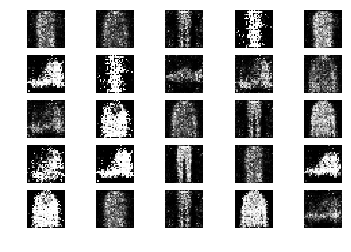

3001 [D loss: 0.631017, acc.: 62.50%] [G loss: 0.948868]
3002 [D loss: 0.728554, acc.: 48.44%] [G loss: 1.013755]
3003 [D loss: 0.679819, acc.: 51.56%] [G loss: 0.872022]
3004 [D loss: 0.590493, acc.: 75.00%] [G loss: 0.905136]
3005 [D loss: 0.668669, acc.: 59.38%] [G loss: 0.842173]
3006 [D loss: 0.638537, acc.: 60.94%] [G loss: 0.778479]
3007 [D loss: 0.600733, acc.: 60.94%] [G loss: 0.795538]
3008 [D loss: 0.572823, acc.: 70.31%] [G loss: 0.883455]
3009 [D loss: 0.657605, acc.: 51.56%] [G loss: 0.846003]
3010 [D loss: 0.619909, acc.: 57.81%] [G loss: 0.993346]
3011 [D loss: 0.644862, acc.: 59.38%] [G loss: 1.046816]
3012 [D loss: 0.611589, acc.: 62.50%] [G loss: 0.992449]
3013 [D loss: 0.589092, acc.: 71.88%] [G loss: 1.049297]
3014 [D loss: 0.691653, acc.: 51.56%] [G loss: 0.928509]
3015 [D loss: 0.571656, acc.: 73.44%] [G loss: 0.886350]
3016 [D loss: 0.629215, acc.: 64.06%] [G loss: 0.982918]
3017 [D loss: 0.694870, acc.: 43.75%] [G loss: 0.883591]
3018 [D loss: 0.646152, acc.: 6

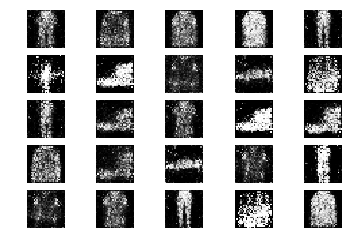

3101 [D loss: 0.626207, acc.: 59.38%] [G loss: 1.011606]
3102 [D loss: 0.647844, acc.: 54.69%] [G loss: 1.060120]
3103 [D loss: 0.697071, acc.: 51.56%] [G loss: 0.994470]
3104 [D loss: 0.598406, acc.: 71.88%] [G loss: 0.944857]
3105 [D loss: 0.687490, acc.: 53.12%] [G loss: 0.946480]
3106 [D loss: 0.650958, acc.: 60.94%] [G loss: 1.083409]
3107 [D loss: 0.666288, acc.: 59.38%] [G loss: 0.959911]
3108 [D loss: 0.627261, acc.: 54.69%] [G loss: 0.968634]
3109 [D loss: 0.637008, acc.: 57.81%] [G loss: 1.031656]
3110 [D loss: 0.647328, acc.: 60.94%] [G loss: 1.009870]
3111 [D loss: 0.629469, acc.: 62.50%] [G loss: 1.047450]
3112 [D loss: 0.629454, acc.: 62.50%] [G loss: 1.029231]
3113 [D loss: 0.642977, acc.: 56.25%] [G loss: 0.995736]
3114 [D loss: 0.693148, acc.: 57.81%] [G loss: 0.878809]
3115 [D loss: 0.638033, acc.: 56.25%] [G loss: 1.061081]
3116 [D loss: 0.600309, acc.: 68.75%] [G loss: 1.037494]
3117 [D loss: 0.602142, acc.: 64.06%] [G loss: 1.002705]
3118 [D loss: 0.692624, acc.: 5

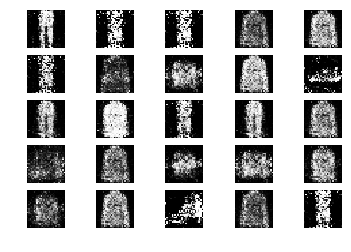

3201 [D loss: 0.593384, acc.: 68.75%] [G loss: 1.008485]
3202 [D loss: 0.604084, acc.: 67.19%] [G loss: 0.993925]
3203 [D loss: 0.643962, acc.: 57.81%] [G loss: 1.086411]
3204 [D loss: 0.599639, acc.: 67.19%] [G loss: 1.133028]
3205 [D loss: 0.629567, acc.: 57.81%] [G loss: 0.970835]
3206 [D loss: 0.635161, acc.: 62.50%] [G loss: 0.925894]
3207 [D loss: 0.588170, acc.: 75.00%] [G loss: 0.954800]
3208 [D loss: 0.611101, acc.: 64.06%] [G loss: 1.009366]
3209 [D loss: 0.637232, acc.: 59.38%] [G loss: 0.968452]
3210 [D loss: 0.618816, acc.: 64.06%] [G loss: 0.985259]
3211 [D loss: 0.559901, acc.: 70.31%] [G loss: 1.061427]
3212 [D loss: 0.683359, acc.: 53.12%] [G loss: 1.051544]
3213 [D loss: 0.638171, acc.: 54.69%] [G loss: 1.138806]
3214 [D loss: 0.676498, acc.: 56.25%] [G loss: 1.158201]
3215 [D loss: 0.569645, acc.: 65.62%] [G loss: 1.150120]
3216 [D loss: 0.624217, acc.: 70.31%] [G loss: 1.136162]
3217 [D loss: 0.604959, acc.: 70.31%] [G loss: 1.062561]
3218 [D loss: 0.616723, acc.: 6

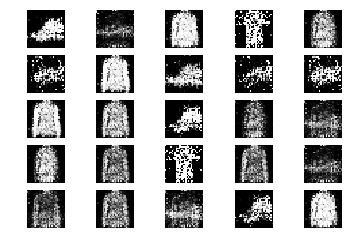

3301 [D loss: 0.626642, acc.: 67.19%] [G loss: 1.030804]
3302 [D loss: 0.564681, acc.: 73.44%] [G loss: 0.970552]
3303 [D loss: 0.622147, acc.: 60.94%] [G loss: 0.914286]
3304 [D loss: 0.606779, acc.: 67.19%] [G loss: 1.043438]
3305 [D loss: 0.647753, acc.: 57.81%] [G loss: 0.895669]
3306 [D loss: 0.593029, acc.: 78.12%] [G loss: 0.951721]
3307 [D loss: 0.612569, acc.: 56.25%] [G loss: 0.910362]
3308 [D loss: 0.730847, acc.: 48.44%] [G loss: 0.944707]
3309 [D loss: 0.523303, acc.: 76.56%] [G loss: 1.087461]
3310 [D loss: 0.656099, acc.: 59.38%] [G loss: 1.114755]
3311 [D loss: 0.588085, acc.: 67.19%] [G loss: 1.015843]
3312 [D loss: 0.602224, acc.: 54.69%] [G loss: 1.109069]
3313 [D loss: 0.632260, acc.: 71.88%] [G loss: 1.082304]
3314 [D loss: 0.578049, acc.: 73.44%] [G loss: 1.133141]
3315 [D loss: 0.629650, acc.: 65.62%] [G loss: 1.064397]
3316 [D loss: 0.606791, acc.: 57.81%] [G loss: 1.123339]
3317 [D loss: 0.531357, acc.: 71.88%] [G loss: 1.227666]
3318 [D loss: 0.620826, acc.: 6

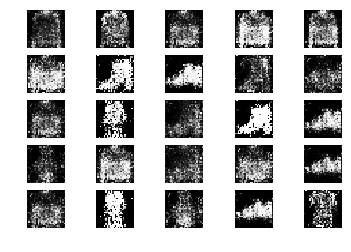

3401 [D loss: 0.587778, acc.: 68.75%] [G loss: 1.161039]
3402 [D loss: 0.669199, acc.: 57.81%] [G loss: 1.174861]
3403 [D loss: 0.636998, acc.: 65.62%] [G loss: 1.063800]
3404 [D loss: 0.595372, acc.: 73.44%] [G loss: 1.226065]
3405 [D loss: 0.522214, acc.: 75.00%] [G loss: 1.181638]
3406 [D loss: 0.680879, acc.: 50.00%] [G loss: 1.119537]
3407 [D loss: 0.628174, acc.: 67.19%] [G loss: 1.191445]
3408 [D loss: 0.621878, acc.: 59.38%] [G loss: 1.195658]
3409 [D loss: 0.692213, acc.: 54.69%] [G loss: 1.191655]
3410 [D loss: 0.651269, acc.: 54.69%] [G loss: 1.076130]
3411 [D loss: 0.624825, acc.: 64.06%] [G loss: 1.024583]
3412 [D loss: 0.585655, acc.: 67.19%] [G loss: 1.025907]
3413 [D loss: 0.680812, acc.: 56.25%] [G loss: 1.085156]
3414 [D loss: 0.677589, acc.: 62.50%] [G loss: 1.270853]
3415 [D loss: 0.640497, acc.: 64.06%] [G loss: 1.068576]
3416 [D loss: 0.791212, acc.: 45.31%] [G loss: 0.917228]
3417 [D loss: 0.648315, acc.: 64.06%] [G loss: 1.039517]
3418 [D loss: 0.607677, acc.: 6

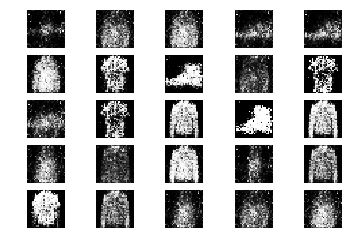

3501 [D loss: 0.542554, acc.: 75.00%] [G loss: 1.053511]
3502 [D loss: 0.703955, acc.: 60.94%] [G loss: 1.048055]
3503 [D loss: 0.636363, acc.: 57.81%] [G loss: 1.068490]
3504 [D loss: 0.612856, acc.: 67.19%] [G loss: 0.971612]
3505 [D loss: 0.687191, acc.: 56.25%] [G loss: 0.935820]
3506 [D loss: 0.643315, acc.: 57.81%] [G loss: 1.036523]
3507 [D loss: 0.665187, acc.: 57.81%] [G loss: 1.034550]
3508 [D loss: 0.675708, acc.: 64.06%] [G loss: 0.955559]
3509 [D loss: 0.563667, acc.: 67.19%] [G loss: 0.941631]
3510 [D loss: 0.673359, acc.: 53.12%] [G loss: 0.926136]
3511 [D loss: 0.630390, acc.: 65.62%] [G loss: 1.068950]
3512 [D loss: 0.615246, acc.: 64.06%] [G loss: 0.943177]
3513 [D loss: 0.635687, acc.: 62.50%] [G loss: 0.879099]
3514 [D loss: 0.698860, acc.: 46.88%] [G loss: 0.942110]
3515 [D loss: 0.697268, acc.: 56.25%] [G loss: 0.910879]
3516 [D loss: 0.712746, acc.: 51.56%] [G loss: 0.993203]
3517 [D loss: 0.614769, acc.: 68.75%] [G loss: 1.255133]
3518 [D loss: 0.674565, acc.: 5

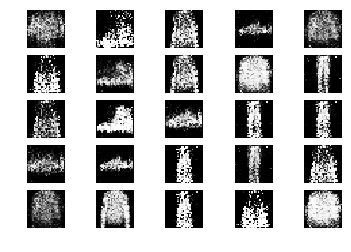

3601 [D loss: 0.542787, acc.: 76.56%] [G loss: 1.014579]
3602 [D loss: 0.655978, acc.: 60.94%] [G loss: 1.043697]
3603 [D loss: 0.604171, acc.: 67.19%] [G loss: 1.100994]
3604 [D loss: 0.677567, acc.: 60.94%] [G loss: 1.012337]
3605 [D loss: 0.594590, acc.: 67.19%] [G loss: 1.062047]
3606 [D loss: 0.666802, acc.: 65.62%] [G loss: 0.973491]
3607 [D loss: 0.583290, acc.: 60.94%] [G loss: 1.082696]
3608 [D loss: 0.616589, acc.: 60.94%] [G loss: 1.101217]
3609 [D loss: 0.670272, acc.: 56.25%] [G loss: 1.052735]
3610 [D loss: 0.678503, acc.: 60.94%] [G loss: 1.079711]
3611 [D loss: 0.603166, acc.: 68.75%] [G loss: 0.932079]
3612 [D loss: 0.637235, acc.: 64.06%] [G loss: 1.044197]
3613 [D loss: 0.741747, acc.: 51.56%] [G loss: 1.021380]
3614 [D loss: 0.604412, acc.: 62.50%] [G loss: 1.166793]
3615 [D loss: 0.770078, acc.: 43.75%] [G loss: 1.073948]
3616 [D loss: 0.650774, acc.: 60.94%] [G loss: 0.999914]
3617 [D loss: 0.661691, acc.: 53.12%] [G loss: 0.983888]
3618 [D loss: 0.586458, acc.: 7

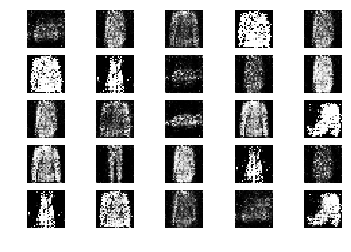

3701 [D loss: 0.737793, acc.: 53.12%] [G loss: 1.027360]
3702 [D loss: 0.620441, acc.: 59.38%] [G loss: 1.335314]
3703 [D loss: 0.512297, acc.: 76.56%] [G loss: 1.355886]
3704 [D loss: 0.646867, acc.: 60.94%] [G loss: 1.095652]
3705 [D loss: 0.565600, acc.: 73.44%] [G loss: 1.210061]
3706 [D loss: 0.650768, acc.: 60.94%] [G loss: 1.153466]
3707 [D loss: 0.657557, acc.: 57.81%] [G loss: 1.278296]
3708 [D loss: 0.635028, acc.: 65.62%] [G loss: 1.191363]
3709 [D loss: 0.543813, acc.: 65.62%] [G loss: 1.241519]
3710 [D loss: 0.681051, acc.: 53.12%] [G loss: 1.047385]
3711 [D loss: 0.703910, acc.: 50.00%] [G loss: 1.147183]
3712 [D loss: 0.575536, acc.: 71.88%] [G loss: 1.234594]
3713 [D loss: 0.521424, acc.: 78.12%] [G loss: 1.143023]
3714 [D loss: 0.507751, acc.: 79.69%] [G loss: 1.196469]
3715 [D loss: 0.632803, acc.: 60.94%] [G loss: 1.188162]
3716 [D loss: 0.649318, acc.: 60.94%] [G loss: 1.037907]
3717 [D loss: 0.628929, acc.: 64.06%] [G loss: 1.095753]
3718 [D loss: 0.643117, acc.: 6

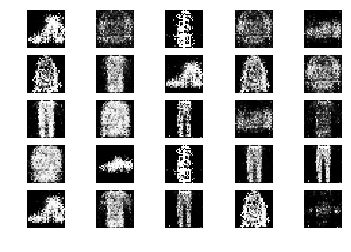

3801 [D loss: 0.705330, acc.: 53.12%] [G loss: 0.975128]
3802 [D loss: 0.650652, acc.: 59.38%] [G loss: 0.958639]
3803 [D loss: 0.716260, acc.: 50.00%] [G loss: 1.069463]
3804 [D loss: 0.576156, acc.: 65.62%] [G loss: 1.065518]
3805 [D loss: 0.687900, acc.: 62.50%] [G loss: 1.152747]
3806 [D loss: 0.718329, acc.: 62.50%] [G loss: 0.962586]
3807 [D loss: 0.615818, acc.: 70.31%] [G loss: 0.924855]
3808 [D loss: 0.775744, acc.: 53.12%] [G loss: 0.962748]
3809 [D loss: 0.636825, acc.: 60.94%] [G loss: 1.056014]
3810 [D loss: 0.720547, acc.: 62.50%] [G loss: 1.001691]
3811 [D loss: 0.607019, acc.: 67.19%] [G loss: 1.056044]
3812 [D loss: 0.639983, acc.: 56.25%] [G loss: 1.057274]
3813 [D loss: 0.653289, acc.: 67.19%] [G loss: 1.108954]
3814 [D loss: 0.709161, acc.: 48.44%] [G loss: 1.122349]
3815 [D loss: 0.607440, acc.: 70.31%] [G loss: 1.032329]
3816 [D loss: 0.646641, acc.: 59.38%] [G loss: 1.180708]
3817 [D loss: 0.603840, acc.: 67.19%] [G loss: 1.061596]
3818 [D loss: 0.662650, acc.: 6

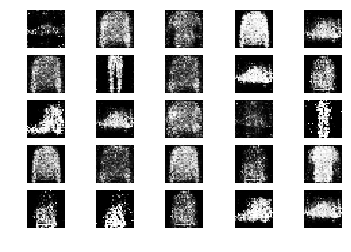

3901 [D loss: 0.642629, acc.: 68.75%] [G loss: 1.058847]
3902 [D loss: 0.599730, acc.: 71.88%] [G loss: 0.896318]
3903 [D loss: 0.629461, acc.: 62.50%] [G loss: 0.911292]
3904 [D loss: 0.651229, acc.: 60.94%] [G loss: 0.847214]
3905 [D loss: 0.626898, acc.: 62.50%] [G loss: 0.899457]
3906 [D loss: 0.662916, acc.: 60.94%] [G loss: 0.988327]
3907 [D loss: 0.654070, acc.: 59.38%] [G loss: 0.906892]
3908 [D loss: 0.723393, acc.: 45.31%] [G loss: 1.039020]
3909 [D loss: 0.638081, acc.: 60.94%] [G loss: 1.058602]
3910 [D loss: 0.693389, acc.: 56.25%] [G loss: 0.976093]
3911 [D loss: 0.644309, acc.: 56.25%] [G loss: 1.067122]
3912 [D loss: 0.676633, acc.: 56.25%] [G loss: 1.037549]
3913 [D loss: 0.633934, acc.: 56.25%] [G loss: 1.025842]
3914 [D loss: 0.688097, acc.: 48.44%] [G loss: 0.986873]
3915 [D loss: 0.634851, acc.: 64.06%] [G loss: 0.891322]
3916 [D loss: 0.632450, acc.: 64.06%] [G loss: 0.938806]
3917 [D loss: 0.704570, acc.: 51.56%] [G loss: 0.896468]
3918 [D loss: 0.643359, acc.: 5

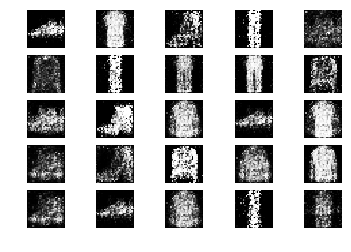

4001 [D loss: 0.657546, acc.: 62.50%] [G loss: 0.846018]
4002 [D loss: 0.663419, acc.: 60.94%] [G loss: 0.931925]
4003 [D loss: 0.604624, acc.: 67.19%] [G loss: 1.036762]
4004 [D loss: 0.589686, acc.: 75.00%] [G loss: 0.994119]
4005 [D loss: 0.600881, acc.: 64.06%] [G loss: 0.993148]
4006 [D loss: 0.660674, acc.: 64.06%] [G loss: 0.963781]
4007 [D loss: 0.667660, acc.: 60.94%] [G loss: 0.923314]
4008 [D loss: 0.609983, acc.: 60.94%] [G loss: 1.120369]
4009 [D loss: 0.736813, acc.: 40.62%] [G loss: 1.023157]
4010 [D loss: 0.644058, acc.: 59.38%] [G loss: 1.052723]
4011 [D loss: 0.682762, acc.: 54.69%] [G loss: 1.017866]
4012 [D loss: 0.655469, acc.: 54.69%] [G loss: 0.972077]
4013 [D loss: 0.647233, acc.: 56.25%] [G loss: 1.002376]
4014 [D loss: 0.636313, acc.: 65.62%] [G loss: 1.002202]
4015 [D loss: 0.627176, acc.: 60.94%] [G loss: 0.968141]
4016 [D loss: 0.708421, acc.: 43.75%] [G loss: 0.928181]
4017 [D loss: 0.639150, acc.: 64.06%] [G loss: 0.937161]
4018 [D loss: 0.571468, acc.: 6

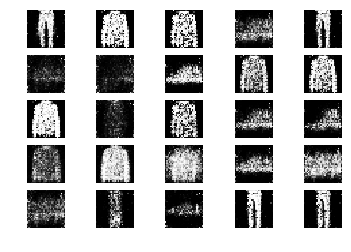

4101 [D loss: 0.660120, acc.: 57.81%] [G loss: 0.970451]
4102 [D loss: 0.656449, acc.: 60.94%] [G loss: 0.932965]
4103 [D loss: 0.584589, acc.: 73.44%] [G loss: 0.842012]
4104 [D loss: 0.588142, acc.: 73.44%] [G loss: 1.027012]
4105 [D loss: 0.721212, acc.: 54.69%] [G loss: 0.965510]
4106 [D loss: 0.699645, acc.: 57.81%] [G loss: 0.909809]
4107 [D loss: 0.665036, acc.: 57.81%] [G loss: 0.915417]
4108 [D loss: 0.642133, acc.: 62.50%] [G loss: 0.927552]
4109 [D loss: 0.589833, acc.: 64.06%] [G loss: 0.976251]
4110 [D loss: 0.678710, acc.: 51.56%] [G loss: 1.007762]
4111 [D loss: 0.644175, acc.: 57.81%] [G loss: 0.965121]
4112 [D loss: 0.658792, acc.: 67.19%] [G loss: 0.969953]
4113 [D loss: 0.603067, acc.: 60.94%] [G loss: 1.030218]
4114 [D loss: 0.580280, acc.: 71.88%] [G loss: 0.922550]
4115 [D loss: 0.619245, acc.: 65.62%] [G loss: 0.886664]
4116 [D loss: 0.681130, acc.: 56.25%] [G loss: 0.981571]
4117 [D loss: 0.626615, acc.: 60.94%] [G loss: 0.951734]
4118 [D loss: 0.594623, acc.: 7

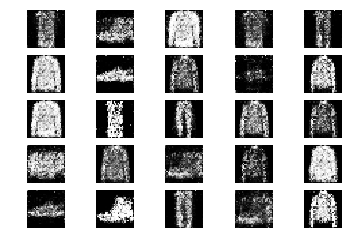

4201 [D loss: 0.640440, acc.: 59.38%] [G loss: 1.000264]
4202 [D loss: 0.636425, acc.: 65.62%] [G loss: 0.939160]
4203 [D loss: 0.625930, acc.: 59.38%] [G loss: 0.970340]
4204 [D loss: 0.667717, acc.: 59.38%] [G loss: 1.043075]
4205 [D loss: 0.635451, acc.: 56.25%] [G loss: 0.898920]
4206 [D loss: 0.684412, acc.: 60.94%] [G loss: 0.857197]
4207 [D loss: 0.706411, acc.: 59.38%] [G loss: 0.869943]
4208 [D loss: 0.661682, acc.: 67.19%] [G loss: 0.837479]
4209 [D loss: 0.685121, acc.: 50.00%] [G loss: 0.897280]
4210 [D loss: 0.600683, acc.: 68.75%] [G loss: 0.900803]
4211 [D loss: 0.712960, acc.: 57.81%] [G loss: 0.903553]
4212 [D loss: 0.641739, acc.: 59.38%] [G loss: 0.980784]
4213 [D loss: 0.611613, acc.: 65.62%] [G loss: 0.978798]
4214 [D loss: 0.600844, acc.: 65.62%] [G loss: 1.019319]
4215 [D loss: 0.669350, acc.: 60.94%] [G loss: 0.976767]
4216 [D loss: 0.622972, acc.: 67.19%] [G loss: 0.953200]
4217 [D loss: 0.657967, acc.: 59.38%] [G loss: 0.908170]
4218 [D loss: 0.686006, acc.: 4

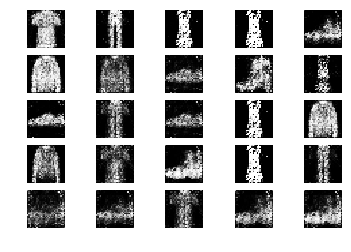

4301 [D loss: 0.713519, acc.: 46.88%] [G loss: 0.927714]
4302 [D loss: 0.753119, acc.: 48.44%] [G loss: 0.897568]
4303 [D loss: 0.703266, acc.: 54.69%] [G loss: 1.000365]
4304 [D loss: 0.695523, acc.: 60.94%] [G loss: 1.014945]
4305 [D loss: 0.693550, acc.: 59.38%] [G loss: 0.968619]
4306 [D loss: 0.683270, acc.: 51.56%] [G loss: 0.897326]
4307 [D loss: 0.741576, acc.: 50.00%] [G loss: 1.063090]
4308 [D loss: 0.657360, acc.: 56.25%] [G loss: 0.994932]
4309 [D loss: 0.670973, acc.: 57.81%] [G loss: 1.082078]
4310 [D loss: 0.663959, acc.: 57.81%] [G loss: 0.889471]
4311 [D loss: 0.627308, acc.: 67.19%] [G loss: 0.991457]
4312 [D loss: 0.673400, acc.: 60.94%] [G loss: 0.940107]
4313 [D loss: 0.606988, acc.: 71.88%] [G loss: 0.927794]
4314 [D loss: 0.651837, acc.: 67.19%] [G loss: 0.988577]
4315 [D loss: 0.687635, acc.: 67.19%] [G loss: 0.983087]
4316 [D loss: 0.671867, acc.: 53.12%] [G loss: 1.001869]
4317 [D loss: 0.622512, acc.: 67.19%] [G loss: 0.945700]
4318 [D loss: 0.654758, acc.: 5

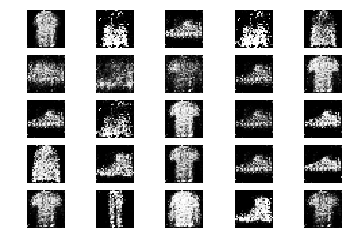

4401 [D loss: 0.624643, acc.: 64.06%] [G loss: 0.918206]
4402 [D loss: 0.696631, acc.: 54.69%] [G loss: 0.945878]
4403 [D loss: 0.721075, acc.: 43.75%] [G loss: 0.875303]
4404 [D loss: 0.743033, acc.: 43.75%] [G loss: 0.859345]
4405 [D loss: 0.709124, acc.: 50.00%] [G loss: 0.962114]
4406 [D loss: 0.700403, acc.: 45.31%] [G loss: 0.856599]
4407 [D loss: 0.699821, acc.: 50.00%] [G loss: 0.994318]
4408 [D loss: 0.679762, acc.: 57.81%] [G loss: 0.981252]
4409 [D loss: 0.719526, acc.: 50.00%] [G loss: 0.933928]
4410 [D loss: 0.680559, acc.: 40.62%] [G loss: 0.948889]
4411 [D loss: 0.692924, acc.: 57.81%] [G loss: 0.894383]
4412 [D loss: 0.742215, acc.: 48.44%] [G loss: 0.887488]
4413 [D loss: 0.693355, acc.: 62.50%] [G loss: 0.925656]
4414 [D loss: 0.641286, acc.: 64.06%] [G loss: 0.950295]
4415 [D loss: 0.678028, acc.: 53.12%] [G loss: 1.177854]
4416 [D loss: 0.690906, acc.: 51.56%] [G loss: 0.932098]
4417 [D loss: 0.609658, acc.: 65.62%] [G loss: 0.953448]
4418 [D loss: 0.688046, acc.: 4

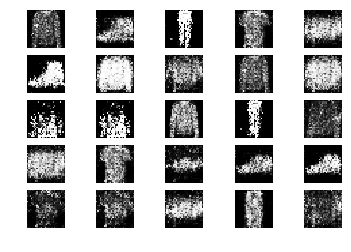

4501 [D loss: 0.616218, acc.: 73.44%] [G loss: 0.856304]
4502 [D loss: 0.690100, acc.: 53.12%] [G loss: 0.908884]
4503 [D loss: 0.657297, acc.: 57.81%] [G loss: 0.843479]
4504 [D loss: 0.708197, acc.: 59.38%] [G loss: 0.903929]
4505 [D loss: 0.714617, acc.: 50.00%] [G loss: 0.757327]
4506 [D loss: 0.685781, acc.: 54.69%] [G loss: 0.861006]
4507 [D loss: 0.672718, acc.: 59.38%] [G loss: 0.816905]
4508 [D loss: 0.617567, acc.: 67.19%] [G loss: 0.862940]
4509 [D loss: 0.730516, acc.: 46.88%] [G loss: 0.876263]
4510 [D loss: 0.655914, acc.: 57.81%] [G loss: 0.827115]
4511 [D loss: 0.648889, acc.: 62.50%] [G loss: 0.918793]
4512 [D loss: 0.678702, acc.: 59.38%] [G loss: 0.899619]
4513 [D loss: 0.686021, acc.: 54.69%] [G loss: 0.902996]
4514 [D loss: 0.651526, acc.: 54.69%] [G loss: 0.842762]
4515 [D loss: 0.667813, acc.: 51.56%] [G loss: 0.843724]
4516 [D loss: 0.693643, acc.: 50.00%] [G loss: 0.822170]
4517 [D loss: 0.702143, acc.: 50.00%] [G loss: 0.828620]
4518 [D loss: 0.616068, acc.: 6

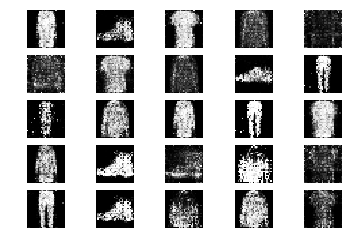

4601 [D loss: 0.643563, acc.: 65.62%] [G loss: 0.849678]
4602 [D loss: 0.729964, acc.: 50.00%] [G loss: 0.906201]
4603 [D loss: 0.659977, acc.: 50.00%] [G loss: 0.860623]
4604 [D loss: 0.656557, acc.: 53.12%] [G loss: 0.874444]
4605 [D loss: 0.686396, acc.: 62.50%] [G loss: 0.890794]
4606 [D loss: 0.603649, acc.: 65.62%] [G loss: 0.876529]
4607 [D loss: 0.643021, acc.: 56.25%] [G loss: 0.901215]
4608 [D loss: 0.735649, acc.: 43.75%] [G loss: 0.841018]
4609 [D loss: 0.713451, acc.: 51.56%] [G loss: 1.006209]
4610 [D loss: 0.699059, acc.: 53.12%] [G loss: 0.830494]
4611 [D loss: 0.714547, acc.: 48.44%] [G loss: 0.863079]
4612 [D loss: 0.700152, acc.: 53.12%] [G loss: 0.887521]
4613 [D loss: 0.696118, acc.: 56.25%] [G loss: 0.860724]
4614 [D loss: 0.711676, acc.: 45.31%] [G loss: 0.863721]
4615 [D loss: 0.685269, acc.: 54.69%] [G loss: 0.876863]
4616 [D loss: 0.747496, acc.: 42.19%] [G loss: 0.814678]
4617 [D loss: 0.649679, acc.: 67.19%] [G loss: 0.923866]
4618 [D loss: 0.749943, acc.: 4

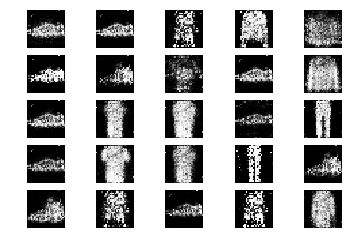

4701 [D loss: 0.665512, acc.: 48.44%] [G loss: 0.917268]
4702 [D loss: 0.658683, acc.: 62.50%] [G loss: 0.893617]
4703 [D loss: 0.653649, acc.: 67.19%] [G loss: 0.864188]
4704 [D loss: 0.695487, acc.: 56.25%] [G loss: 0.909590]
4705 [D loss: 0.645371, acc.: 65.62%] [G loss: 0.933927]
4706 [D loss: 0.698340, acc.: 53.12%] [G loss: 0.840219]
4707 [D loss: 0.706146, acc.: 50.00%] [G loss: 0.832496]
4708 [D loss: 0.651282, acc.: 56.25%] [G loss: 0.873255]
4709 [D loss: 0.656391, acc.: 59.38%] [G loss: 0.939429]
4710 [D loss: 0.713374, acc.: 51.56%] [G loss: 0.875868]
4711 [D loss: 0.670137, acc.: 51.56%] [G loss: 0.867402]
4712 [D loss: 0.685871, acc.: 56.25%] [G loss: 0.915695]
4713 [D loss: 0.685071, acc.: 51.56%] [G loss: 0.856267]
4714 [D loss: 0.627294, acc.: 62.50%] [G loss: 0.909853]
4715 [D loss: 0.711785, acc.: 42.19%] [G loss: 0.919373]
4716 [D loss: 0.654829, acc.: 60.94%] [G loss: 0.910166]
4717 [D loss: 0.649605, acc.: 50.00%] [G loss: 0.814631]
4718 [D loss: 0.636614, acc.: 5

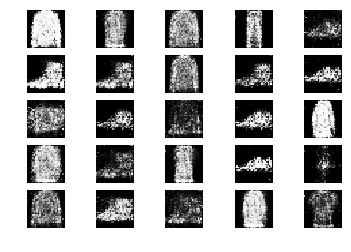

4801 [D loss: 0.696265, acc.: 64.06%] [G loss: 0.834048]
4802 [D loss: 0.686173, acc.: 54.69%] [G loss: 0.805520]
4803 [D loss: 0.759065, acc.: 45.31%] [G loss: 0.707617]
4804 [D loss: 0.676716, acc.: 59.38%] [G loss: 0.806421]
4805 [D loss: 0.685278, acc.: 56.25%] [G loss: 0.807382]
4806 [D loss: 0.676074, acc.: 43.75%] [G loss: 0.813989]
4807 [D loss: 0.693404, acc.: 57.81%] [G loss: 0.872406]
4808 [D loss: 0.613337, acc.: 64.06%] [G loss: 0.905385]
4809 [D loss: 0.705345, acc.: 46.88%] [G loss: 0.808508]
4810 [D loss: 0.679280, acc.: 59.38%] [G loss: 0.825433]
4811 [D loss: 0.707446, acc.: 48.44%] [G loss: 0.897222]
4812 [D loss: 0.686925, acc.: 51.56%] [G loss: 0.858517]
4813 [D loss: 0.756540, acc.: 42.19%] [G loss: 0.925454]
4814 [D loss: 0.682107, acc.: 51.56%] [G loss: 0.980699]
4815 [D loss: 0.651079, acc.: 53.12%] [G loss: 0.950661]
4816 [D loss: 0.632198, acc.: 56.25%] [G loss: 0.910154]
4817 [D loss: 0.671106, acc.: 51.56%] [G loss: 0.865548]
4818 [D loss: 0.707462, acc.: 4

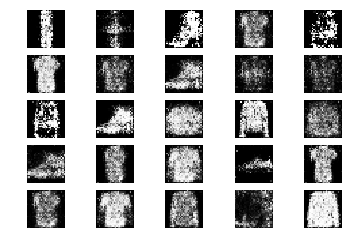

4901 [D loss: 0.737072, acc.: 39.06%] [G loss: 0.846083]
4902 [D loss: 0.699443, acc.: 54.69%] [G loss: 0.924772]
4903 [D loss: 0.757392, acc.: 42.19%] [G loss: 0.921696]
4904 [D loss: 0.705888, acc.: 45.31%] [G loss: 0.898375]
4905 [D loss: 0.661600, acc.: 59.38%] [G loss: 0.844256]
4906 [D loss: 0.646854, acc.: 65.62%] [G loss: 0.814438]
4907 [D loss: 0.717023, acc.: 53.12%] [G loss: 0.880563]
4908 [D loss: 0.681507, acc.: 53.12%] [G loss: 0.886806]
4909 [D loss: 0.645699, acc.: 62.50%] [G loss: 0.925382]
4910 [D loss: 0.686894, acc.: 51.56%] [G loss: 0.915067]
4911 [D loss: 0.682589, acc.: 64.06%] [G loss: 0.828108]
4912 [D loss: 0.663038, acc.: 57.81%] [G loss: 0.853759]
4913 [D loss: 0.709064, acc.: 53.12%] [G loss: 0.818322]
4914 [D loss: 0.699580, acc.: 50.00%] [G loss: 0.813307]
4915 [D loss: 0.673317, acc.: 56.25%] [G loss: 0.818653]
4916 [D loss: 0.637638, acc.: 62.50%] [G loss: 0.873193]
4917 [D loss: 0.645250, acc.: 59.38%] [G loss: 0.926517]
4918 [D loss: 0.668420, acc.: 5

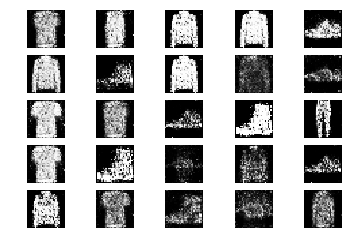

5001 [D loss: 0.742463, acc.: 48.44%] [G loss: 0.855866]
5002 [D loss: 0.702115, acc.: 57.81%] [G loss: 0.880162]
5003 [D loss: 0.643867, acc.: 54.69%] [G loss: 0.855412]
5004 [D loss: 0.722251, acc.: 53.12%] [G loss: 0.830924]
5005 [D loss: 0.729770, acc.: 46.88%] [G loss: 0.825093]
5006 [D loss: 0.724301, acc.: 48.44%] [G loss: 0.863973]
5007 [D loss: 0.727878, acc.: 42.19%] [G loss: 0.809452]
5008 [D loss: 0.719709, acc.: 46.88%] [G loss: 0.785218]
5009 [D loss: 0.671448, acc.: 57.81%] [G loss: 0.878965]
5010 [D loss: 0.723736, acc.: 54.69%] [G loss: 0.813132]
5011 [D loss: 0.678564, acc.: 53.12%] [G loss: 0.848108]
5012 [D loss: 0.674557, acc.: 56.25%] [G loss: 0.847515]
5013 [D loss: 0.718203, acc.: 57.81%] [G loss: 0.849333]
5014 [D loss: 0.669767, acc.: 50.00%] [G loss: 0.881386]
5015 [D loss: 0.692520, acc.: 50.00%] [G loss: 0.818272]
5016 [D loss: 0.624647, acc.: 64.06%] [G loss: 0.852454]
5017 [D loss: 0.744571, acc.: 46.88%] [G loss: 0.865206]
5018 [D loss: 0.651784, acc.: 5

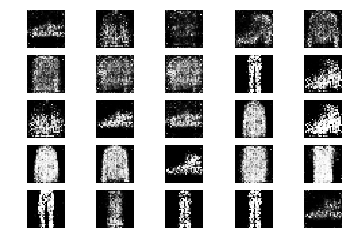

5101 [D loss: 0.655711, acc.: 62.50%] [G loss: 0.956055]
5102 [D loss: 0.691920, acc.: 60.94%] [G loss: 0.878419]
5103 [D loss: 0.654688, acc.: 57.81%] [G loss: 0.834721]
5104 [D loss: 0.672155, acc.: 56.25%] [G loss: 0.860845]
5105 [D loss: 0.717804, acc.: 51.56%] [G loss: 0.866256]
5106 [D loss: 0.663730, acc.: 59.38%] [G loss: 0.809429]
5107 [D loss: 0.681804, acc.: 53.12%] [G loss: 0.851762]
5108 [D loss: 0.679261, acc.: 56.25%] [G loss: 0.928196]
5109 [D loss: 0.677121, acc.: 56.25%] [G loss: 0.816022]
5110 [D loss: 0.613528, acc.: 67.19%] [G loss: 0.830505]
5111 [D loss: 0.689429, acc.: 57.81%] [G loss: 0.828276]
5112 [D loss: 0.684130, acc.: 53.12%] [G loss: 0.815700]
5113 [D loss: 0.651696, acc.: 54.69%] [G loss: 0.852688]
5114 [D loss: 0.657095, acc.: 57.81%] [G loss: 0.863575]
5115 [D loss: 0.659091, acc.: 54.69%] [G loss: 0.885759]
5116 [D loss: 0.689624, acc.: 48.44%] [G loss: 0.814159]
5117 [D loss: 0.664184, acc.: 46.88%] [G loss: 0.785536]
5118 [D loss: 0.655470, acc.: 5

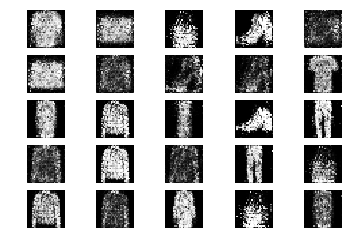

5201 [D loss: 0.657754, acc.: 54.69%] [G loss: 0.859903]
5202 [D loss: 0.653180, acc.: 56.25%] [G loss: 0.795841]
5203 [D loss: 0.720621, acc.: 50.00%] [G loss: 0.730121]
5204 [D loss: 0.647147, acc.: 64.06%] [G loss: 0.705819]
5205 [D loss: 0.737037, acc.: 50.00%] [G loss: 0.826868]
5206 [D loss: 0.673068, acc.: 53.12%] [G loss: 0.819717]
5207 [D loss: 0.726309, acc.: 42.19%] [G loss: 0.877947]
5208 [D loss: 0.678792, acc.: 57.81%] [G loss: 0.901205]
5209 [D loss: 0.734697, acc.: 50.00%] [G loss: 0.863229]
5210 [D loss: 0.646611, acc.: 60.94%] [G loss: 0.838372]
5211 [D loss: 0.709707, acc.: 53.12%] [G loss: 0.837033]
5212 [D loss: 0.675715, acc.: 54.69%] [G loss: 0.894736]
5213 [D loss: 0.679653, acc.: 50.00%] [G loss: 0.860731]
5214 [D loss: 0.701641, acc.: 51.56%] [G loss: 0.805228]
5215 [D loss: 0.712528, acc.: 48.44%] [G loss: 0.956684]
5216 [D loss: 0.667264, acc.: 54.69%] [G loss: 0.849445]
5217 [D loss: 0.760877, acc.: 43.75%] [G loss: 0.808556]
5218 [D loss: 0.660990, acc.: 5

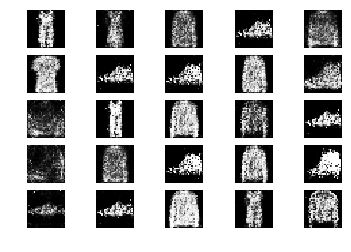

5301 [D loss: 0.632921, acc.: 65.62%] [G loss: 0.809280]
5302 [D loss: 0.581206, acc.: 70.31%] [G loss: 0.808441]
5303 [D loss: 0.705184, acc.: 56.25%] [G loss: 0.890256]
5304 [D loss: 0.709755, acc.: 53.12%] [G loss: 0.918398]
5305 [D loss: 0.668302, acc.: 56.25%] [G loss: 1.012979]
5306 [D loss: 0.625211, acc.: 65.62%] [G loss: 0.987135]
5307 [D loss: 0.755291, acc.: 46.88%] [G loss: 0.842331]
5308 [D loss: 0.656630, acc.: 57.81%] [G loss: 0.821001]
5309 [D loss: 0.679380, acc.: 59.38%] [G loss: 0.877201]
5310 [D loss: 0.629287, acc.: 68.75%] [G loss: 0.892818]
5311 [D loss: 0.692191, acc.: 50.00%] [G loss: 0.907716]
5312 [D loss: 0.621250, acc.: 68.75%] [G loss: 0.904268]
5313 [D loss: 0.662882, acc.: 57.81%] [G loss: 0.851597]
5314 [D loss: 0.684564, acc.: 57.81%] [G loss: 0.885414]
5315 [D loss: 0.658125, acc.: 64.06%] [G loss: 0.976167]
5316 [D loss: 0.613285, acc.: 60.94%] [G loss: 0.946880]
5317 [D loss: 0.683188, acc.: 60.94%] [G loss: 0.905639]
5318 [D loss: 0.630475, acc.: 5

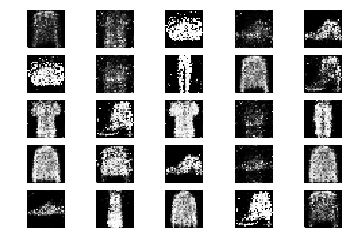

5401 [D loss: 0.716425, acc.: 62.50%] [G loss: 0.891792]
5402 [D loss: 0.590708, acc.: 71.88%] [G loss: 0.938393]
5403 [D loss: 0.657816, acc.: 67.19%] [G loss: 0.865967]
5404 [D loss: 0.712396, acc.: 51.56%] [G loss: 0.788562]
5405 [D loss: 0.694794, acc.: 56.25%] [G loss: 0.867828]
5406 [D loss: 0.692191, acc.: 48.44%] [G loss: 0.825886]
5407 [D loss: 0.716781, acc.: 51.56%] [G loss: 0.917371]
5408 [D loss: 0.676043, acc.: 59.38%] [G loss: 0.803832]
5409 [D loss: 0.759944, acc.: 39.06%] [G loss: 0.758270]
5410 [D loss: 0.717461, acc.: 46.88%] [G loss: 0.837971]
5411 [D loss: 0.700654, acc.: 50.00%] [G loss: 0.784460]
5412 [D loss: 0.675513, acc.: 46.88%] [G loss: 0.823944]
5413 [D loss: 0.640672, acc.: 54.69%] [G loss: 0.900840]
5414 [D loss: 0.687700, acc.: 56.25%] [G loss: 0.794682]
5415 [D loss: 0.638829, acc.: 65.62%] [G loss: 0.797997]
5416 [D loss: 0.622991, acc.: 64.06%] [G loss: 0.779686]
5417 [D loss: 0.652610, acc.: 57.81%] [G loss: 0.952351]
5418 [D loss: 0.678511, acc.: 6

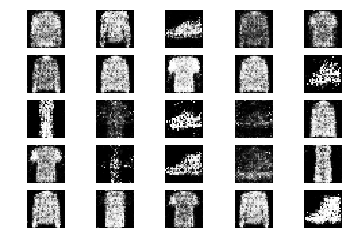

5501 [D loss: 0.637945, acc.: 57.81%] [G loss: 0.890338]
5502 [D loss: 0.672933, acc.: 62.50%] [G loss: 0.861621]
5503 [D loss: 0.657284, acc.: 62.50%] [G loss: 0.910527]
5504 [D loss: 0.628482, acc.: 67.19%] [G loss: 0.859424]
5505 [D loss: 0.692974, acc.: 51.56%] [G loss: 0.807777]
5506 [D loss: 0.694125, acc.: 53.12%] [G loss: 0.825981]
5507 [D loss: 0.666473, acc.: 51.56%] [G loss: 0.788773]
5508 [D loss: 0.744771, acc.: 48.44%] [G loss: 0.881157]
5509 [D loss: 0.691080, acc.: 50.00%] [G loss: 0.799127]
5510 [D loss: 0.704003, acc.: 51.56%] [G loss: 0.996146]
5511 [D loss: 0.644036, acc.: 57.81%] [G loss: 0.919359]
5512 [D loss: 0.698064, acc.: 51.56%] [G loss: 0.923186]
5513 [D loss: 0.667837, acc.: 57.81%] [G loss: 0.967816]
5514 [D loss: 0.694818, acc.: 50.00%] [G loss: 0.924965]
5515 [D loss: 0.733436, acc.: 42.19%] [G loss: 0.908329]
5516 [D loss: 0.662588, acc.: 54.69%] [G loss: 0.856880]
5517 [D loss: 0.677880, acc.: 48.44%] [G loss: 0.764611]
5518 [D loss: 0.634186, acc.: 5

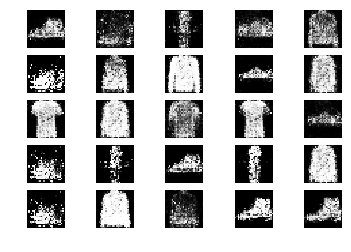

5601 [D loss: 0.647021, acc.: 73.44%] [G loss: 0.845341]
5602 [D loss: 0.661758, acc.: 57.81%] [G loss: 0.830457]
5603 [D loss: 0.684124, acc.: 45.31%] [G loss: 0.923142]
5604 [D loss: 0.604486, acc.: 65.62%] [G loss: 0.952866]
5605 [D loss: 0.651688, acc.: 56.25%] [G loss: 0.905055]
5606 [D loss: 0.705948, acc.: 54.69%] [G loss: 0.904670]
5607 [D loss: 0.667502, acc.: 51.56%] [G loss: 0.895234]
5608 [D loss: 0.665846, acc.: 56.25%] [G loss: 0.954673]
5609 [D loss: 0.691304, acc.: 54.69%] [G loss: 0.953617]
5610 [D loss: 0.730033, acc.: 46.88%] [G loss: 0.856460]
5611 [D loss: 0.646626, acc.: 53.12%] [G loss: 0.956365]
5612 [D loss: 0.617250, acc.: 59.38%] [G loss: 1.090240]
5613 [D loss: 0.719730, acc.: 51.56%] [G loss: 0.983181]
5614 [D loss: 0.685548, acc.: 53.12%] [G loss: 0.980882]
5615 [D loss: 0.675799, acc.: 60.94%] [G loss: 0.874663]
5616 [D loss: 0.692620, acc.: 53.12%] [G loss: 0.895710]
5617 [D loss: 0.615281, acc.: 60.94%] [G loss: 0.926338]
5618 [D loss: 0.670502, acc.: 5

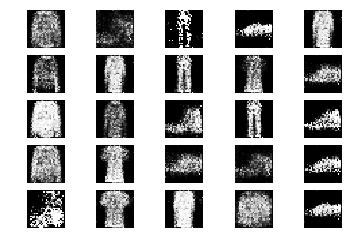

5701 [D loss: 0.614873, acc.: 64.06%] [G loss: 1.002555]
5702 [D loss: 0.697849, acc.: 51.56%] [G loss: 0.865678]
5703 [D loss: 0.626126, acc.: 67.19%] [G loss: 0.786499]
5704 [D loss: 0.725034, acc.: 51.56%] [G loss: 0.863961]
5705 [D loss: 0.625243, acc.: 60.94%] [G loss: 0.929606]
5706 [D loss: 0.697835, acc.: 50.00%] [G loss: 0.955769]
5707 [D loss: 0.651733, acc.: 65.62%] [G loss: 0.944612]
5708 [D loss: 0.711299, acc.: 51.56%] [G loss: 0.848801]
5709 [D loss: 0.771474, acc.: 37.50%] [G loss: 0.925317]
5710 [D loss: 0.734562, acc.: 53.12%] [G loss: 0.782070]
5711 [D loss: 0.662382, acc.: 57.81%] [G loss: 0.854692]
5712 [D loss: 0.693807, acc.: 60.94%] [G loss: 0.809809]
5713 [D loss: 0.697484, acc.: 51.56%] [G loss: 0.928273]
5714 [D loss: 0.710351, acc.: 53.12%] [G loss: 0.825634]
5715 [D loss: 0.715852, acc.: 50.00%] [G loss: 0.908626]
5716 [D loss: 0.664941, acc.: 54.69%] [G loss: 0.889008]
5717 [D loss: 0.675444, acc.: 57.81%] [G loss: 0.826968]
5718 [D loss: 0.725489, acc.: 4

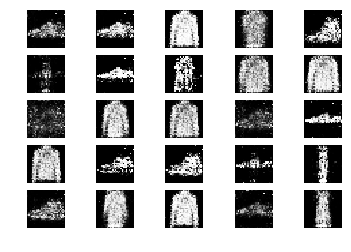

5801 [D loss: 0.673514, acc.: 56.25%] [G loss: 0.861053]
5802 [D loss: 0.712002, acc.: 51.56%] [G loss: 0.804365]
5803 [D loss: 0.677421, acc.: 65.62%] [G loss: 0.926576]
5804 [D loss: 0.675505, acc.: 54.69%] [G loss: 0.875028]
5805 [D loss: 0.655254, acc.: 57.81%] [G loss: 0.876542]
5806 [D loss: 0.648973, acc.: 60.94%] [G loss: 0.847722]
5807 [D loss: 0.647202, acc.: 54.69%] [G loss: 0.851123]
5808 [D loss: 0.635758, acc.: 60.94%] [G loss: 0.920975]
5809 [D loss: 0.674502, acc.: 46.88%] [G loss: 0.877290]
5810 [D loss: 0.707849, acc.: 48.44%] [G loss: 0.895878]
5811 [D loss: 0.694946, acc.: 56.25%] [G loss: 0.871642]
5812 [D loss: 0.663583, acc.: 56.25%] [G loss: 0.771374]
5813 [D loss: 0.654461, acc.: 57.81%] [G loss: 0.723746]
5814 [D loss: 0.713739, acc.: 37.50%] [G loss: 0.805805]
5815 [D loss: 0.695365, acc.: 54.69%] [G loss: 0.801272]
5816 [D loss: 0.616529, acc.: 62.50%] [G loss: 0.825667]
5817 [D loss: 0.700925, acc.: 40.62%] [G loss: 0.921839]
5818 [D loss: 0.706274, acc.: 4

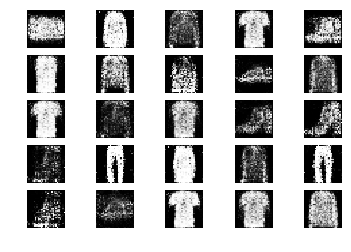

5901 [D loss: 0.683184, acc.: 54.69%] [G loss: 0.896821]
5902 [D loss: 0.654304, acc.: 65.62%] [G loss: 0.886043]
5903 [D loss: 0.690225, acc.: 59.38%] [G loss: 0.840032]
5904 [D loss: 0.708105, acc.: 45.31%] [G loss: 0.897153]
5905 [D loss: 0.717443, acc.: 51.56%] [G loss: 0.775647]
5906 [D loss: 0.694287, acc.: 53.12%] [G loss: 0.753614]
5907 [D loss: 0.749651, acc.: 50.00%] [G loss: 0.828545]
5908 [D loss: 0.652443, acc.: 62.50%] [G loss: 0.843715]
5909 [D loss: 0.653341, acc.: 62.50%] [G loss: 0.921490]
5910 [D loss: 0.663473, acc.: 54.69%] [G loss: 0.974819]
5911 [D loss: 0.683872, acc.: 59.38%] [G loss: 0.854187]
5912 [D loss: 0.646193, acc.: 60.94%] [G loss: 0.864334]
5913 [D loss: 0.722802, acc.: 50.00%] [G loss: 0.861682]
5914 [D loss: 0.688147, acc.: 59.38%] [G loss: 0.837699]
5915 [D loss: 0.665641, acc.: 59.38%] [G loss: 0.884592]
5916 [D loss: 0.634500, acc.: 64.06%] [G loss: 0.893249]
5917 [D loss: 0.650926, acc.: 60.94%] [G loss: 0.866359]
5918 [D loss: 0.656540, acc.: 6

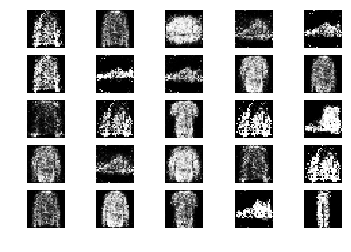

6001 [D loss: 0.640621, acc.: 60.94%] [G loss: 0.996262]
6002 [D loss: 0.743106, acc.: 43.75%] [G loss: 1.018260]
6003 [D loss: 0.714801, acc.: 51.56%] [G loss: 0.845426]
6004 [D loss: 0.611427, acc.: 76.56%] [G loss: 0.821238]
6005 [D loss: 0.631451, acc.: 68.75%] [G loss: 0.816698]
6006 [D loss: 0.719053, acc.: 53.12%] [G loss: 0.882167]
6007 [D loss: 0.662939, acc.: 60.94%] [G loss: 0.909611]
6008 [D loss: 0.736779, acc.: 53.12%] [G loss: 0.900543]
6009 [D loss: 0.650404, acc.: 62.50%] [G loss: 0.830078]
6010 [D loss: 0.687636, acc.: 59.38%] [G loss: 0.877247]
6011 [D loss: 0.718869, acc.: 43.75%] [G loss: 0.826376]
6012 [D loss: 0.675393, acc.: 54.69%] [G loss: 0.856286]
6013 [D loss: 0.660712, acc.: 53.12%] [G loss: 0.933972]
6014 [D loss: 0.689282, acc.: 53.12%] [G loss: 0.849624]
6015 [D loss: 0.637291, acc.: 64.06%] [G loss: 0.820933]
6016 [D loss: 0.650330, acc.: 65.62%] [G loss: 0.860065]
6017 [D loss: 0.679385, acc.: 60.94%] [G loss: 0.905751]
6018 [D loss: 0.694308, acc.: 5

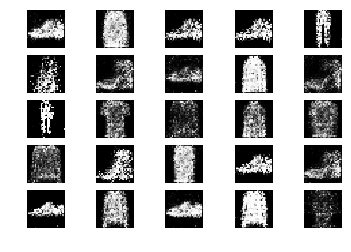

6101 [D loss: 0.644442, acc.: 59.38%] [G loss: 0.806402]
6102 [D loss: 0.624091, acc.: 60.94%] [G loss: 0.882478]
6103 [D loss: 0.722500, acc.: 54.69%] [G loss: 0.951217]
6104 [D loss: 0.659277, acc.: 59.38%] [G loss: 0.956588]
6105 [D loss: 0.601847, acc.: 70.31%] [G loss: 0.967888]
6106 [D loss: 0.659519, acc.: 57.81%] [G loss: 1.022637]
6107 [D loss: 0.628772, acc.: 65.62%] [G loss: 0.988650]
6108 [D loss: 0.649307, acc.: 56.25%] [G loss: 0.873753]
6109 [D loss: 0.680959, acc.: 59.38%] [G loss: 0.871061]
6110 [D loss: 0.718173, acc.: 43.75%] [G loss: 0.927847]
6111 [D loss: 0.662489, acc.: 65.62%] [G loss: 0.823840]
6112 [D loss: 0.675895, acc.: 65.62%] [G loss: 0.920072]
6113 [D loss: 0.669050, acc.: 51.56%] [G loss: 0.857997]
6114 [D loss: 0.729318, acc.: 50.00%] [G loss: 0.821860]
6115 [D loss: 0.621336, acc.: 64.06%] [G loss: 0.857289]
6116 [D loss: 0.614867, acc.: 62.50%] [G loss: 0.879410]
6117 [D loss: 0.673926, acc.: 56.25%] [G loss: 0.835855]
6118 [D loss: 0.627442, acc.: 6

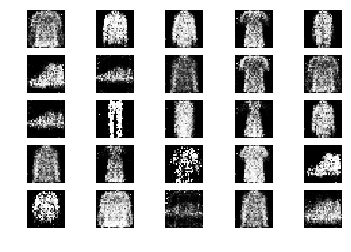

6201 [D loss: 0.667160, acc.: 59.38%] [G loss: 0.901349]
6202 [D loss: 0.667623, acc.: 59.38%] [G loss: 0.879370]
6203 [D loss: 0.668186, acc.: 51.56%] [G loss: 0.812193]
6204 [D loss: 0.721940, acc.: 50.00%] [G loss: 0.772670]
6205 [D loss: 0.683414, acc.: 57.81%] [G loss: 0.761658]
6206 [D loss: 0.648365, acc.: 51.56%] [G loss: 0.856774]
6207 [D loss: 0.708144, acc.: 50.00%] [G loss: 0.954864]
6208 [D loss: 0.673209, acc.: 60.94%] [G loss: 0.928261]
6209 [D loss: 0.677064, acc.: 57.81%] [G loss: 0.911810]
6210 [D loss: 0.669931, acc.: 56.25%] [G loss: 0.873377]
6211 [D loss: 0.644390, acc.: 64.06%] [G loss: 0.899680]
6212 [D loss: 0.640098, acc.: 60.94%] [G loss: 0.848676]
6213 [D loss: 0.650175, acc.: 65.62%] [G loss: 0.888978]
6214 [D loss: 0.621216, acc.: 73.44%] [G loss: 0.894275]
6215 [D loss: 0.621305, acc.: 70.31%] [G loss: 0.949359]
6216 [D loss: 0.668649, acc.: 62.50%] [G loss: 0.887809]
6217 [D loss: 0.707679, acc.: 54.69%] [G loss: 0.916052]
6218 [D loss: 0.650506, acc.: 6

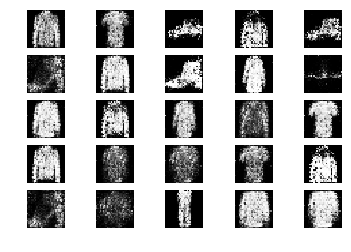

6301 [D loss: 0.689597, acc.: 56.25%] [G loss: 0.906601]
6302 [D loss: 0.689319, acc.: 57.81%] [G loss: 0.970703]
6303 [D loss: 0.674849, acc.: 57.81%] [G loss: 0.953857]
6304 [D loss: 0.660657, acc.: 54.69%] [G loss: 0.875510]
6305 [D loss: 0.651008, acc.: 67.19%] [G loss: 1.008288]
6306 [D loss: 0.640397, acc.: 62.50%] [G loss: 0.970411]
6307 [D loss: 0.642204, acc.: 68.75%] [G loss: 0.910460]
6308 [D loss: 0.645857, acc.: 56.25%] [G loss: 1.004753]
6309 [D loss: 0.720719, acc.: 46.88%] [G loss: 0.841213]
6310 [D loss: 0.660103, acc.: 59.38%] [G loss: 0.877733]
6311 [D loss: 0.610216, acc.: 75.00%] [G loss: 0.896601]
6312 [D loss: 0.675007, acc.: 59.38%] [G loss: 0.892033]
6313 [D loss: 0.672910, acc.: 56.25%] [G loss: 0.963694]
6314 [D loss: 0.679848, acc.: 56.25%] [G loss: 0.989072]
6315 [D loss: 0.645314, acc.: 60.94%] [G loss: 0.916936]
6316 [D loss: 0.612734, acc.: 59.38%] [G loss: 0.918557]
6317 [D loss: 0.744329, acc.: 53.12%] [G loss: 0.862071]
6318 [D loss: 0.732519, acc.: 4

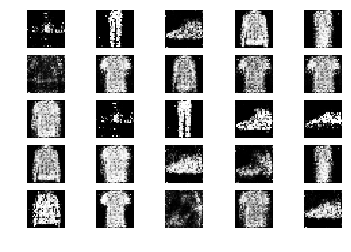

6401 [D loss: 0.687820, acc.: 57.81%] [G loss: 0.837862]
6402 [D loss: 0.674503, acc.: 53.12%] [G loss: 0.846071]
6403 [D loss: 0.594121, acc.: 70.31%] [G loss: 0.917463]
6404 [D loss: 0.607408, acc.: 70.31%] [G loss: 0.885806]
6405 [D loss: 0.664067, acc.: 51.56%] [G loss: 0.929808]
6406 [D loss: 0.697843, acc.: 46.88%] [G loss: 0.822631]
6407 [D loss: 0.719556, acc.: 48.44%] [G loss: 0.874652]
6408 [D loss: 0.696947, acc.: 54.69%] [G loss: 0.870845]
6409 [D loss: 0.642161, acc.: 60.94%] [G loss: 0.904407]
6410 [D loss: 0.625152, acc.: 64.06%] [G loss: 0.935236]
6411 [D loss: 0.647292, acc.: 57.81%] [G loss: 0.947028]
6412 [D loss: 0.698344, acc.: 59.38%] [G loss: 0.836320]
6413 [D loss: 0.645568, acc.: 60.94%] [G loss: 0.878452]
6414 [D loss: 0.632818, acc.: 65.62%] [G loss: 0.893811]
6415 [D loss: 0.658943, acc.: 60.94%] [G loss: 0.859164]
6416 [D loss: 0.685296, acc.: 56.25%] [G loss: 0.856965]
6417 [D loss: 0.694812, acc.: 45.31%] [G loss: 0.857948]
6418 [D loss: 0.643710, acc.: 6

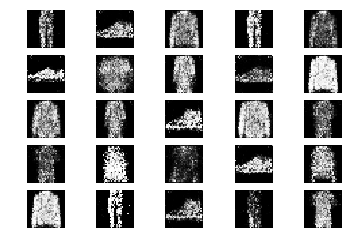

6501 [D loss: 0.663315, acc.: 57.81%] [G loss: 0.853534]
6502 [D loss: 0.689808, acc.: 53.12%] [G loss: 0.830503]
6503 [D loss: 0.654228, acc.: 57.81%] [G loss: 0.904419]
6504 [D loss: 0.614838, acc.: 67.19%] [G loss: 0.889752]
6505 [D loss: 0.676187, acc.: 57.81%] [G loss: 0.841548]
6506 [D loss: 0.698779, acc.: 51.56%] [G loss: 0.838715]
6507 [D loss: 0.668420, acc.: 54.69%] [G loss: 0.836606]
6508 [D loss: 0.671996, acc.: 60.94%] [G loss: 0.843355]
6509 [D loss: 0.664753, acc.: 59.38%] [G loss: 0.893141]
6510 [D loss: 0.646741, acc.: 67.19%] [G loss: 0.953088]
6511 [D loss: 0.728591, acc.: 50.00%] [G loss: 1.039210]
6512 [D loss: 0.678796, acc.: 59.38%] [G loss: 1.037382]
6513 [D loss: 0.664987, acc.: 60.94%] [G loss: 0.829905]
6514 [D loss: 0.699836, acc.: 51.56%] [G loss: 0.863059]
6515 [D loss: 0.686476, acc.: 54.69%] [G loss: 0.910692]
6516 [D loss: 0.683668, acc.: 57.81%] [G loss: 1.001988]
6517 [D loss: 0.752276, acc.: 56.25%] [G loss: 0.930382]
6518 [D loss: 0.684576, acc.: 5

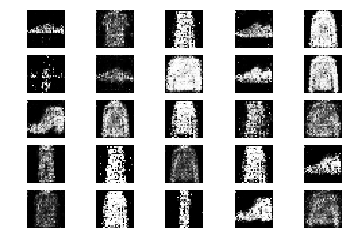

6601 [D loss: 0.714320, acc.: 45.31%] [G loss: 0.773867]
6602 [D loss: 0.642312, acc.: 62.50%] [G loss: 0.808990]
6603 [D loss: 0.658635, acc.: 62.50%] [G loss: 0.813011]
6604 [D loss: 0.664465, acc.: 65.62%] [G loss: 0.901584]
6605 [D loss: 0.613894, acc.: 62.50%] [G loss: 0.891629]
6606 [D loss: 0.676859, acc.: 53.12%] [G loss: 0.921374]
6607 [D loss: 0.671661, acc.: 50.00%] [G loss: 0.833312]
6608 [D loss: 0.671731, acc.: 50.00%] [G loss: 0.785356]
6609 [D loss: 0.661184, acc.: 64.06%] [G loss: 0.779372]
6610 [D loss: 0.655608, acc.: 60.94%] [G loss: 0.854931]
6611 [D loss: 0.621600, acc.: 64.06%] [G loss: 0.855278]
6612 [D loss: 0.698979, acc.: 51.56%] [G loss: 0.898248]
6613 [D loss: 0.623612, acc.: 68.75%] [G loss: 1.055130]
6614 [D loss: 0.599090, acc.: 60.94%] [G loss: 0.995417]
6615 [D loss: 0.695136, acc.: 57.81%] [G loss: 0.990970]
6616 [D loss: 0.692063, acc.: 57.81%] [G loss: 0.886814]
6617 [D loss: 0.645478, acc.: 67.19%] [G loss: 0.834621]
6618 [D loss: 0.635915, acc.: 5

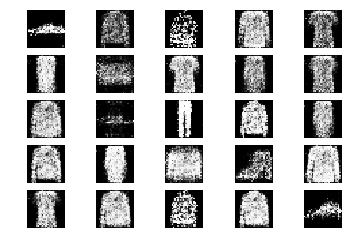

6701 [D loss: 0.649422, acc.: 64.06%] [G loss: 0.893025]
6702 [D loss: 0.705410, acc.: 42.19%] [G loss: 0.930914]
6703 [D loss: 0.663161, acc.: 62.50%] [G loss: 0.854022]
6704 [D loss: 0.665434, acc.: 59.38%] [G loss: 0.877205]
6705 [D loss: 0.737172, acc.: 54.69%] [G loss: 0.894057]
6706 [D loss: 0.703598, acc.: 59.38%] [G loss: 0.917569]
6707 [D loss: 0.696571, acc.: 48.44%] [G loss: 1.033086]
6708 [D loss: 0.727956, acc.: 48.44%] [G loss: 0.886243]
6709 [D loss: 0.706131, acc.: 39.06%] [G loss: 0.829056]
6710 [D loss: 0.709886, acc.: 48.44%] [G loss: 0.897257]
6711 [D loss: 0.673907, acc.: 60.94%] [G loss: 0.954310]
6712 [D loss: 0.650127, acc.: 56.25%] [G loss: 0.901137]
6713 [D loss: 0.710952, acc.: 48.44%] [G loss: 0.964450]
6714 [D loss: 0.672114, acc.: 64.06%] [G loss: 0.872381]
6715 [D loss: 0.612785, acc.: 62.50%] [G loss: 1.005218]
6716 [D loss: 0.698610, acc.: 48.44%] [G loss: 0.989523]
6717 [D loss: 0.619661, acc.: 68.75%] [G loss: 1.020255]
6718 [D loss: 0.667447, acc.: 7

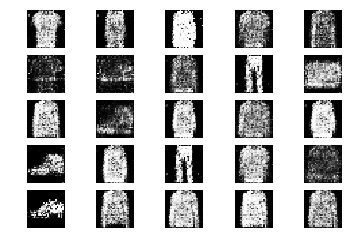

6801 [D loss: 0.663013, acc.: 62.50%] [G loss: 0.842513]
6802 [D loss: 0.663675, acc.: 57.81%] [G loss: 0.856213]
6803 [D loss: 0.694385, acc.: 53.12%] [G loss: 0.865039]
6804 [D loss: 0.679822, acc.: 59.38%] [G loss: 0.934741]
6805 [D loss: 0.665831, acc.: 56.25%] [G loss: 0.927077]
6806 [D loss: 0.614540, acc.: 68.75%] [G loss: 0.946557]
6807 [D loss: 0.653535, acc.: 59.38%] [G loss: 0.939611]
6808 [D loss: 0.643360, acc.: 64.06%] [G loss: 0.983330]
6809 [D loss: 0.648483, acc.: 64.06%] [G loss: 1.060574]
6810 [D loss: 0.689299, acc.: 62.50%] [G loss: 1.057300]
6811 [D loss: 0.594653, acc.: 75.00%] [G loss: 0.952070]
6812 [D loss: 0.617536, acc.: 71.88%] [G loss: 0.945113]
6813 [D loss: 0.665392, acc.: 64.06%] [G loss: 0.833641]
6814 [D loss: 0.726641, acc.: 56.25%] [G loss: 0.870508]
6815 [D loss: 0.682373, acc.: 60.94%] [G loss: 0.874511]
6816 [D loss: 0.679277, acc.: 46.88%] [G loss: 0.972008]
6817 [D loss: 0.645063, acc.: 57.81%] [G loss: 0.979144]
6818 [D loss: 0.674534, acc.: 5

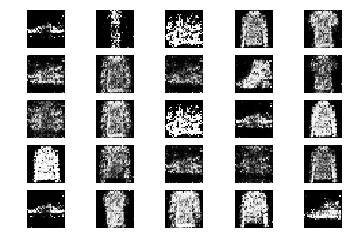

6901 [D loss: 0.647901, acc.: 60.94%] [G loss: 0.954781]
6902 [D loss: 0.634049, acc.: 60.94%] [G loss: 0.929001]
6903 [D loss: 0.690156, acc.: 51.56%] [G loss: 0.933437]
6904 [D loss: 0.665972, acc.: 71.88%] [G loss: 0.882798]
6905 [D loss: 0.630767, acc.: 65.62%] [G loss: 1.038330]
6906 [D loss: 0.653946, acc.: 53.12%] [G loss: 1.024933]
6907 [D loss: 0.631902, acc.: 65.62%] [G loss: 0.912206]
6908 [D loss: 0.670071, acc.: 53.12%] [G loss: 0.898415]
6909 [D loss: 0.639006, acc.: 56.25%] [G loss: 0.935208]
6910 [D loss: 0.622303, acc.: 64.06%] [G loss: 0.945389]
6911 [D loss: 0.683793, acc.: 54.69%] [G loss: 0.978898]
6912 [D loss: 0.649203, acc.: 68.75%] [G loss: 0.934788]
6913 [D loss: 0.652785, acc.: 68.75%] [G loss: 0.922816]
6914 [D loss: 0.659494, acc.: 62.50%] [G loss: 0.977519]
6915 [D loss: 0.603326, acc.: 67.19%] [G loss: 0.975137]
6916 [D loss: 0.635195, acc.: 54.69%] [G loss: 0.919172]
6917 [D loss: 0.673068, acc.: 56.25%] [G loss: 0.968396]
6918 [D loss: 0.632697, acc.: 6

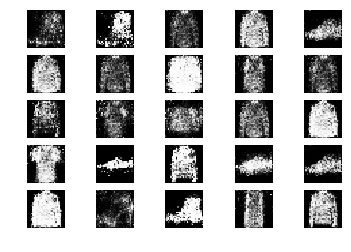

7001 [D loss: 0.662288, acc.: 57.81%] [G loss: 0.882945]
7002 [D loss: 0.653047, acc.: 54.69%] [G loss: 0.866878]
7003 [D loss: 0.644482, acc.: 64.06%] [G loss: 0.985413]
7004 [D loss: 0.672637, acc.: 56.25%] [G loss: 0.885666]
7005 [D loss: 0.664374, acc.: 51.56%] [G loss: 0.914800]
7006 [D loss: 0.649440, acc.: 54.69%] [G loss: 0.931420]
7007 [D loss: 0.626282, acc.: 64.06%] [G loss: 1.023511]
7008 [D loss: 0.669874, acc.: 57.81%] [G loss: 0.811580]
7009 [D loss: 0.663243, acc.: 57.81%] [G loss: 0.953765]
7010 [D loss: 0.698919, acc.: 56.25%] [G loss: 0.920552]
7011 [D loss: 0.672323, acc.: 60.94%] [G loss: 0.862710]
7012 [D loss: 0.635845, acc.: 62.50%] [G loss: 0.875939]
7013 [D loss: 0.681636, acc.: 60.94%] [G loss: 0.901872]
7014 [D loss: 0.663278, acc.: 57.81%] [G loss: 0.955736]
7015 [D loss: 0.641043, acc.: 64.06%] [G loss: 1.001608]
7016 [D loss: 0.675601, acc.: 67.19%] [G loss: 0.874921]
7017 [D loss: 0.623176, acc.: 67.19%] [G loss: 0.772493]
7018 [D loss: 0.658415, acc.: 5

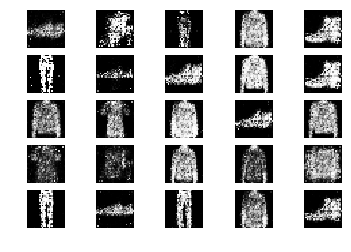

7101 [D loss: 0.652183, acc.: 62.50%] [G loss: 0.921303]
7102 [D loss: 0.736177, acc.: 48.44%] [G loss: 0.903655]
7103 [D loss: 0.667888, acc.: 53.12%] [G loss: 0.971346]
7104 [D loss: 0.640134, acc.: 64.06%] [G loss: 0.976909]
7105 [D loss: 0.660863, acc.: 51.56%] [G loss: 0.876442]
7106 [D loss: 0.647114, acc.: 56.25%] [G loss: 0.953442]
7107 [D loss: 0.655987, acc.: 59.38%] [G loss: 1.028282]
7108 [D loss: 0.695791, acc.: 57.81%] [G loss: 0.931056]
7109 [D loss: 0.648483, acc.: 57.81%] [G loss: 0.861223]
7110 [D loss: 0.728258, acc.: 45.31%] [G loss: 0.935115]
7111 [D loss: 0.614603, acc.: 67.19%] [G loss: 0.895518]
7112 [D loss: 0.662272, acc.: 59.38%] [G loss: 0.853219]
7113 [D loss: 0.682799, acc.: 62.50%] [G loss: 0.898018]
7114 [D loss: 0.680208, acc.: 51.56%] [G loss: 0.900608]
7115 [D loss: 0.650663, acc.: 62.50%] [G loss: 0.903623]
7116 [D loss: 0.628474, acc.: 60.94%] [G loss: 0.916622]
7117 [D loss: 0.671611, acc.: 56.25%] [G loss: 0.915237]
7118 [D loss: 0.696067, acc.: 5

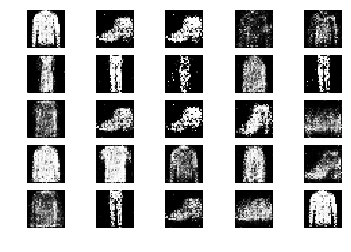

7201 [D loss: 0.762200, acc.: 50.00%] [G loss: 1.053165]
7202 [D loss: 0.651775, acc.: 59.38%] [G loss: 1.180871]
7203 [D loss: 0.708779, acc.: 50.00%] [G loss: 1.140353]
7204 [D loss: 0.816815, acc.: 54.69%] [G loss: 0.860991]
7205 [D loss: 0.713853, acc.: 50.00%] [G loss: 0.874968]
7206 [D loss: 0.737668, acc.: 54.69%] [G loss: 0.890064]
7207 [D loss: 0.652427, acc.: 67.19%] [G loss: 1.038744]
7208 [D loss: 0.651461, acc.: 70.31%] [G loss: 1.014578]
7209 [D loss: 0.674006, acc.: 56.25%] [G loss: 1.042524]
7210 [D loss: 0.674175, acc.: 56.25%] [G loss: 1.043881]
7211 [D loss: 0.653111, acc.: 62.50%] [G loss: 0.979041]
7212 [D loss: 0.626953, acc.: 65.62%] [G loss: 0.898019]
7213 [D loss: 0.606396, acc.: 73.44%] [G loss: 0.984980]
7214 [D loss: 0.626447, acc.: 67.19%] [G loss: 0.935851]
7215 [D loss: 0.603445, acc.: 75.00%] [G loss: 0.873700]
7216 [D loss: 0.605270, acc.: 67.19%] [G loss: 0.912030]
7217 [D loss: 0.588552, acc.: 70.31%] [G loss: 0.954477]
7218 [D loss: 0.595037, acc.: 6

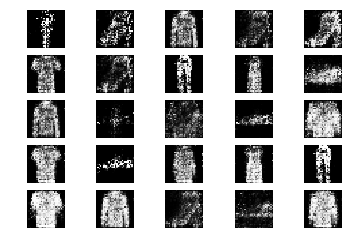

7301 [D loss: 0.643420, acc.: 71.88%] [G loss: 0.921830]
7302 [D loss: 0.724552, acc.: 50.00%] [G loss: 0.877756]
7303 [D loss: 0.620436, acc.: 71.88%] [G loss: 0.865428]
7304 [D loss: 0.714400, acc.: 64.06%] [G loss: 0.837974]
7305 [D loss: 0.661316, acc.: 51.56%] [G loss: 0.822831]
7306 [D loss: 0.687999, acc.: 42.19%] [G loss: 0.954245]
7307 [D loss: 0.648390, acc.: 60.94%] [G loss: 0.941134]
7308 [D loss: 0.636556, acc.: 71.88%] [G loss: 0.915923]
7309 [D loss: 0.657683, acc.: 62.50%] [G loss: 0.909474]
7310 [D loss: 0.672755, acc.: 54.69%] [G loss: 0.926402]
7311 [D loss: 0.622920, acc.: 59.38%] [G loss: 0.914673]
7312 [D loss: 0.665677, acc.: 48.44%] [G loss: 0.939808]
7313 [D loss: 0.616384, acc.: 67.19%] [G loss: 0.971888]
7314 [D loss: 0.640737, acc.: 62.50%] [G loss: 0.917847]
7315 [D loss: 0.688799, acc.: 51.56%] [G loss: 0.901750]
7316 [D loss: 0.635424, acc.: 59.38%] [G loss: 0.899945]
7317 [D loss: 0.693117, acc.: 45.31%] [G loss: 0.899697]
7318 [D loss: 0.691058, acc.: 5

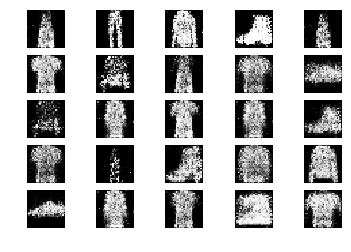

7401 [D loss: 0.690976, acc.: 59.38%] [G loss: 0.861158]
7402 [D loss: 0.631740, acc.: 68.75%] [G loss: 0.863729]
7403 [D loss: 0.626716, acc.: 68.75%] [G loss: 0.836249]
7404 [D loss: 0.692325, acc.: 50.00%] [G loss: 0.855469]
7405 [D loss: 0.689618, acc.: 56.25%] [G loss: 0.903774]
7406 [D loss: 0.662218, acc.: 62.50%] [G loss: 0.886458]
7407 [D loss: 0.698465, acc.: 56.25%] [G loss: 0.892538]
7408 [D loss: 0.646045, acc.: 53.12%] [G loss: 0.865267]
7409 [D loss: 0.759251, acc.: 53.12%] [G loss: 0.935614]
7410 [D loss: 0.690763, acc.: 59.38%] [G loss: 0.922139]
7411 [D loss: 0.698746, acc.: 56.25%] [G loss: 0.905005]
7412 [D loss: 0.700894, acc.: 46.88%] [G loss: 0.968509]
7413 [D loss: 0.732939, acc.: 48.44%] [G loss: 0.841894]
7414 [D loss: 0.655870, acc.: 64.06%] [G loss: 0.905890]
7415 [D loss: 0.645456, acc.: 64.06%] [G loss: 0.812043]
7416 [D loss: 0.659107, acc.: 54.69%] [G loss: 0.895780]
7417 [D loss: 0.693758, acc.: 53.12%] [G loss: 0.857805]
7418 [D loss: 0.677352, acc.: 5

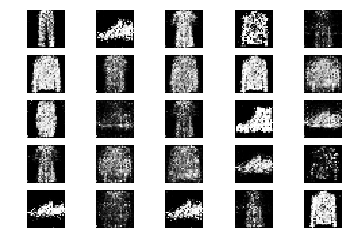

7501 [D loss: 0.647297, acc.: 59.38%] [G loss: 1.012217]
7502 [D loss: 0.664743, acc.: 65.62%] [G loss: 0.928635]
7503 [D loss: 0.627398, acc.: 62.50%] [G loss: 0.898631]
7504 [D loss: 0.746932, acc.: 50.00%] [G loss: 0.906889]
7505 [D loss: 0.724299, acc.: 46.88%] [G loss: 1.019782]
7506 [D loss: 0.674382, acc.: 54.69%] [G loss: 0.950307]
7507 [D loss: 0.659664, acc.: 56.25%] [G loss: 0.928409]
7508 [D loss: 0.688848, acc.: 54.69%] [G loss: 0.941472]
7509 [D loss: 0.719268, acc.: 48.44%] [G loss: 0.933444]
7510 [D loss: 0.628591, acc.: 67.19%] [G loss: 0.861511]
7511 [D loss: 0.621506, acc.: 64.06%] [G loss: 0.905059]
7512 [D loss: 0.634348, acc.: 59.38%] [G loss: 0.846766]
7513 [D loss: 0.593971, acc.: 71.88%] [G loss: 0.949952]
7514 [D loss: 0.662100, acc.: 59.38%] [G loss: 0.942330]
7515 [D loss: 0.621468, acc.: 67.19%] [G loss: 1.030302]
7516 [D loss: 0.692440, acc.: 57.81%] [G loss: 1.042106]
7517 [D loss: 0.634023, acc.: 67.19%] [G loss: 0.856865]
7518 [D loss: 0.669457, acc.: 5

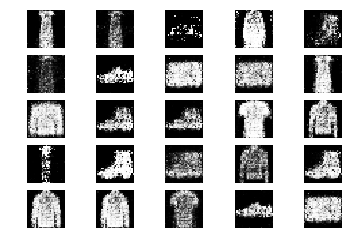

7601 [D loss: 0.663915, acc.: 54.69%] [G loss: 0.832896]
7602 [D loss: 0.667408, acc.: 54.69%] [G loss: 0.903544]
7603 [D loss: 0.631260, acc.: 62.50%] [G loss: 0.914876]
7604 [D loss: 0.647655, acc.: 56.25%] [G loss: 0.935964]
7605 [D loss: 0.639750, acc.: 54.69%] [G loss: 0.915332]
7606 [D loss: 0.654779, acc.: 54.69%] [G loss: 0.945890]
7607 [D loss: 0.666252, acc.: 56.25%] [G loss: 1.009823]
7608 [D loss: 0.678523, acc.: 59.38%] [G loss: 1.058124]
7609 [D loss: 0.661004, acc.: 53.12%] [G loss: 0.884808]
7610 [D loss: 0.675745, acc.: 46.88%] [G loss: 0.917270]
7611 [D loss: 0.681537, acc.: 64.06%] [G loss: 0.911897]
7612 [D loss: 0.635946, acc.: 62.50%] [G loss: 0.961835]
7613 [D loss: 0.638581, acc.: 60.94%] [G loss: 0.941016]
7614 [D loss: 0.646898, acc.: 56.25%] [G loss: 0.903864]
7615 [D loss: 0.596550, acc.: 67.19%] [G loss: 0.882377]
7616 [D loss: 0.618976, acc.: 59.38%] [G loss: 0.950345]
7617 [D loss: 0.690834, acc.: 50.00%] [G loss: 0.988083]
7618 [D loss: 0.707773, acc.: 4

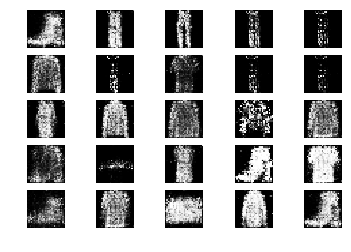

7701 [D loss: 0.762452, acc.: 40.62%] [G loss: 0.879158]
7702 [D loss: 0.690900, acc.: 48.44%] [G loss: 0.990732]
7703 [D loss: 0.657901, acc.: 57.81%] [G loss: 0.945113]
7704 [D loss: 0.745220, acc.: 46.88%] [G loss: 0.892805]
7705 [D loss: 0.656547, acc.: 65.62%] [G loss: 0.981296]
7706 [D loss: 0.634157, acc.: 65.62%] [G loss: 0.979213]
7707 [D loss: 0.636850, acc.: 59.38%] [G loss: 0.947459]
7708 [D loss: 0.684365, acc.: 56.25%] [G loss: 0.963538]
7709 [D loss: 0.664589, acc.: 60.94%] [G loss: 0.923085]
7710 [D loss: 0.612913, acc.: 70.31%] [G loss: 0.877753]
7711 [D loss: 0.664439, acc.: 64.06%] [G loss: 0.812243]
7712 [D loss: 0.648971, acc.: 64.06%] [G loss: 0.788785]
7713 [D loss: 0.644531, acc.: 67.19%] [G loss: 0.913547]
7714 [D loss: 0.702338, acc.: 56.25%] [G loss: 0.871598]
7715 [D loss: 0.679876, acc.: 57.81%] [G loss: 0.891073]
7716 [D loss: 0.654614, acc.: 62.50%] [G loss: 0.855381]
7717 [D loss: 0.587892, acc.: 73.44%] [G loss: 0.838356]
7718 [D loss: 0.675619, acc.: 5

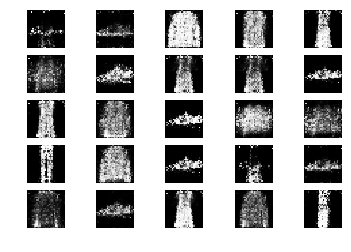

7801 [D loss: 0.608911, acc.: 70.31%] [G loss: 0.980105]
7802 [D loss: 0.593168, acc.: 73.44%] [G loss: 0.972886]
7803 [D loss: 0.672228, acc.: 62.50%] [G loss: 0.952235]
7804 [D loss: 0.686870, acc.: 51.56%] [G loss: 0.918081]
7805 [D loss: 0.611821, acc.: 65.62%] [G loss: 0.964108]
7806 [D loss: 0.643861, acc.: 62.50%] [G loss: 0.985684]
7807 [D loss: 0.631006, acc.: 67.19%] [G loss: 0.937366]
7808 [D loss: 0.664970, acc.: 51.56%] [G loss: 0.941588]
7809 [D loss: 0.639645, acc.: 54.69%] [G loss: 0.879537]
7810 [D loss: 0.655926, acc.: 59.38%] [G loss: 0.816657]
7811 [D loss: 0.681794, acc.: 53.12%] [G loss: 0.785932]
7812 [D loss: 0.667617, acc.: 46.88%] [G loss: 0.875369]
7813 [D loss: 0.660459, acc.: 64.06%] [G loss: 0.917353]
7814 [D loss: 0.651094, acc.: 56.25%] [G loss: 0.957013]
7815 [D loss: 0.683683, acc.: 64.06%] [G loss: 0.956041]
7816 [D loss: 0.629000, acc.: 67.19%] [G loss: 0.975257]
7817 [D loss: 0.745888, acc.: 40.62%] [G loss: 0.867651]
7818 [D loss: 0.653903, acc.: 5

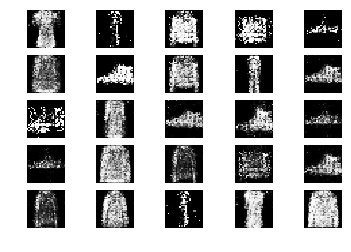

7901 [D loss: 0.683292, acc.: 54.69%] [G loss: 0.965454]
7902 [D loss: 0.673512, acc.: 51.56%] [G loss: 0.978198]
7903 [D loss: 0.707267, acc.: 51.56%] [G loss: 0.893237]
7904 [D loss: 0.686078, acc.: 50.00%] [G loss: 0.842362]
7905 [D loss: 0.664423, acc.: 54.69%] [G loss: 0.937512]
7906 [D loss: 0.675648, acc.: 60.94%] [G loss: 0.913037]
7907 [D loss: 0.599155, acc.: 60.94%] [G loss: 1.032820]
7908 [D loss: 0.671395, acc.: 56.25%] [G loss: 0.933724]
7909 [D loss: 0.683113, acc.: 54.69%] [G loss: 0.913078]
7910 [D loss: 0.691405, acc.: 56.25%] [G loss: 0.923126]
7911 [D loss: 0.697434, acc.: 51.56%] [G loss: 0.897723]
7912 [D loss: 0.726014, acc.: 51.56%] [G loss: 0.884406]
7913 [D loss: 0.692017, acc.: 64.06%] [G loss: 0.905411]
7914 [D loss: 0.635951, acc.: 67.19%] [G loss: 1.007835]
7915 [D loss: 0.640124, acc.: 65.62%] [G loss: 0.890716]
7916 [D loss: 0.672921, acc.: 50.00%] [G loss: 0.867094]
7917 [D loss: 0.614381, acc.: 73.44%] [G loss: 0.869236]
7918 [D loss: 0.721061, acc.: 5

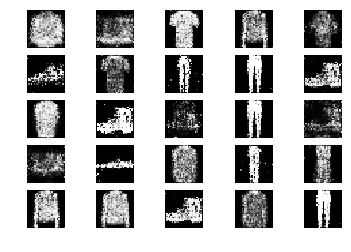

8001 [D loss: 0.662638, acc.: 64.06%] [G loss: 0.917156]
8002 [D loss: 0.726372, acc.: 51.56%] [G loss: 0.947476]
8003 [D loss: 0.697995, acc.: 56.25%] [G loss: 0.890052]
8004 [D loss: 0.735618, acc.: 51.56%] [G loss: 0.891150]
8005 [D loss: 0.704817, acc.: 53.12%] [G loss: 0.844878]
8006 [D loss: 0.679806, acc.: 56.25%] [G loss: 0.841496]
8007 [D loss: 0.613123, acc.: 60.94%] [G loss: 0.893939]
8008 [D loss: 0.644219, acc.: 65.62%] [G loss: 0.967456]
8009 [D loss: 0.651678, acc.: 60.94%] [G loss: 0.982952]
8010 [D loss: 0.697684, acc.: 54.69%] [G loss: 0.980902]
8011 [D loss: 0.710535, acc.: 48.44%] [G loss: 0.935772]
8012 [D loss: 0.709338, acc.: 46.88%] [G loss: 0.885626]
8013 [D loss: 0.706532, acc.: 54.69%] [G loss: 0.833243]
8014 [D loss: 0.647440, acc.: 67.19%] [G loss: 0.898866]
8015 [D loss: 0.641515, acc.: 60.94%] [G loss: 0.883638]
8016 [D loss: 0.628456, acc.: 62.50%] [G loss: 0.974229]
8017 [D loss: 0.717780, acc.: 50.00%] [G loss: 0.849539]
8018 [D loss: 0.622668, acc.: 6

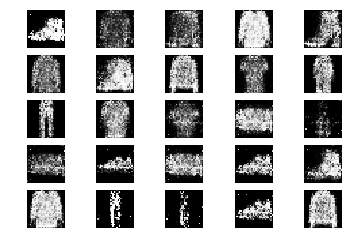

8101 [D loss: 0.633164, acc.: 50.00%] [G loss: 0.827944]
8102 [D loss: 0.716035, acc.: 48.44%] [G loss: 0.841208]
8103 [D loss: 0.617293, acc.: 65.62%] [G loss: 0.958830]
8104 [D loss: 0.696802, acc.: 51.56%] [G loss: 0.941123]
8105 [D loss: 0.694726, acc.: 46.88%] [G loss: 0.876664]
8106 [D loss: 0.740840, acc.: 37.50%] [G loss: 0.813968]
8107 [D loss: 0.696436, acc.: 60.94%] [G loss: 0.789905]
8108 [D loss: 0.742151, acc.: 56.25%] [G loss: 0.786265]
8109 [D loss: 0.638906, acc.: 60.94%] [G loss: 0.917395]
8110 [D loss: 0.704246, acc.: 56.25%] [G loss: 0.979937]
8111 [D loss: 0.693149, acc.: 48.44%] [G loss: 0.961593]
8112 [D loss: 0.712852, acc.: 45.31%] [G loss: 0.929139]
8113 [D loss: 0.655720, acc.: 56.25%] [G loss: 0.905742]
8114 [D loss: 0.620805, acc.: 62.50%] [G loss: 0.930346]
8115 [D loss: 0.666784, acc.: 48.44%] [G loss: 0.964073]
8116 [D loss: 0.668515, acc.: 56.25%] [G loss: 1.011628]
8117 [D loss: 0.687698, acc.: 60.94%] [G loss: 0.899246]
8118 [D loss: 0.722751, acc.: 4

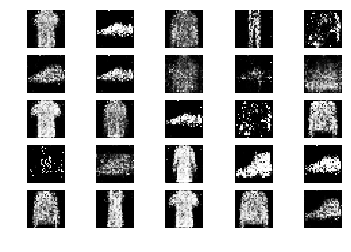

8201 [D loss: 0.686633, acc.: 54.69%] [G loss: 0.928673]
8202 [D loss: 0.614746, acc.: 68.75%] [G loss: 0.879122]
8203 [D loss: 0.591569, acc.: 59.38%] [G loss: 0.892751]
8204 [D loss: 0.658548, acc.: 60.94%] [G loss: 0.988895]
8205 [D loss: 0.777361, acc.: 43.75%] [G loss: 0.926640]
8206 [D loss: 0.643995, acc.: 64.06%] [G loss: 0.842044]
8207 [D loss: 0.650436, acc.: 53.12%] [G loss: 0.884333]
8208 [D loss: 0.635960, acc.: 65.62%] [G loss: 0.852845]
8209 [D loss: 0.625946, acc.: 71.88%] [G loss: 0.950125]
8210 [D loss: 0.645349, acc.: 59.38%] [G loss: 0.912573]
8211 [D loss: 0.607787, acc.: 65.62%] [G loss: 0.956647]
8212 [D loss: 0.698256, acc.: 50.00%] [G loss: 0.953666]
8213 [D loss: 0.649421, acc.: 62.50%] [G loss: 0.904440]
8214 [D loss: 0.657439, acc.: 64.06%] [G loss: 0.954921]
8215 [D loss: 0.633633, acc.: 64.06%] [G loss: 0.855901]
8216 [D loss: 0.603225, acc.: 64.06%] [G loss: 0.878441]
8217 [D loss: 0.589158, acc.: 65.62%] [G loss: 0.945592]
8218 [D loss: 0.683520, acc.: 4

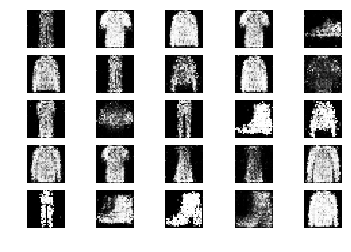

8301 [D loss: 0.874873, acc.: 37.50%] [G loss: 0.847290]
8302 [D loss: 0.736808, acc.: 53.12%] [G loss: 0.824532]
8303 [D loss: 0.659619, acc.: 64.06%] [G loss: 0.836716]
8304 [D loss: 0.700296, acc.: 45.31%] [G loss: 0.875203]
8305 [D loss: 0.650800, acc.: 68.75%] [G loss: 0.906659]
8306 [D loss: 0.702588, acc.: 51.56%] [G loss: 0.933236]
8307 [D loss: 0.727170, acc.: 50.00%] [G loss: 0.842543]
8308 [D loss: 0.682967, acc.: 54.69%] [G loss: 0.836979]
8309 [D loss: 0.637253, acc.: 62.50%] [G loss: 0.900335]
8310 [D loss: 0.677157, acc.: 57.81%] [G loss: 0.874889]
8311 [D loss: 0.673655, acc.: 56.25%] [G loss: 0.871216]
8312 [D loss: 0.710868, acc.: 51.56%] [G loss: 0.880082]
8313 [D loss: 0.647728, acc.: 57.81%] [G loss: 0.924259]
8314 [D loss: 0.719618, acc.: 43.75%] [G loss: 0.853774]
8315 [D loss: 0.714267, acc.: 51.56%] [G loss: 0.919634]
8316 [D loss: 0.658693, acc.: 60.94%] [G loss: 0.863045]
8317 [D loss: 0.628558, acc.: 65.62%] [G loss: 0.913566]
8318 [D loss: 0.670162, acc.: 5

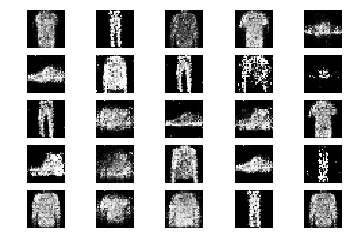

8401 [D loss: 0.692869, acc.: 50.00%] [G loss: 0.858630]
8402 [D loss: 0.714257, acc.: 46.88%] [G loss: 0.866810]
8403 [D loss: 0.678651, acc.: 54.69%] [G loss: 0.845895]
8404 [D loss: 0.637516, acc.: 64.06%] [G loss: 0.859213]
8405 [D loss: 0.714073, acc.: 48.44%] [G loss: 0.920152]
8406 [D loss: 0.631948, acc.: 65.62%] [G loss: 0.957743]
8407 [D loss: 0.659711, acc.: 56.25%] [G loss: 0.935531]
8408 [D loss: 0.778585, acc.: 37.50%] [G loss: 0.811392]
8409 [D loss: 0.706334, acc.: 46.88%] [G loss: 0.827821]
8410 [D loss: 0.664767, acc.: 67.19%] [G loss: 0.841542]
8411 [D loss: 0.634280, acc.: 64.06%] [G loss: 0.974471]
8412 [D loss: 0.615985, acc.: 59.38%] [G loss: 0.927819]
8413 [D loss: 0.755205, acc.: 48.44%] [G loss: 0.929215]
8414 [D loss: 0.647056, acc.: 59.38%] [G loss: 0.922621]
8415 [D loss: 0.669650, acc.: 64.06%] [G loss: 0.870545]
8416 [D loss: 0.695107, acc.: 62.50%] [G loss: 0.895023]
8417 [D loss: 0.684944, acc.: 56.25%] [G loss: 0.913729]
8418 [D loss: 0.690532, acc.: 5

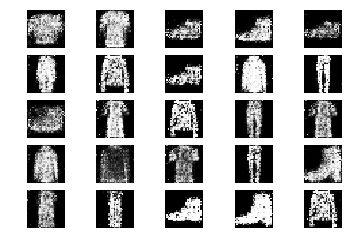

8501 [D loss: 0.621246, acc.: 71.88%] [G loss: 0.851541]
8502 [D loss: 0.640608, acc.: 57.81%] [G loss: 0.791732]
8503 [D loss: 0.730263, acc.: 37.50%] [G loss: 0.820107]
8504 [D loss: 0.713089, acc.: 53.12%] [G loss: 0.825230]
8505 [D loss: 0.671652, acc.: 62.50%] [G loss: 0.812861]
8506 [D loss: 0.694727, acc.: 46.88%] [G loss: 0.927974]
8507 [D loss: 0.750190, acc.: 45.31%] [G loss: 0.870487]
8508 [D loss: 0.721372, acc.: 45.31%] [G loss: 0.858240]
8509 [D loss: 0.672240, acc.: 50.00%] [G loss: 0.829686]
8510 [D loss: 0.622195, acc.: 70.31%] [G loss: 0.858754]
8511 [D loss: 0.697999, acc.: 50.00%] [G loss: 0.829191]
8512 [D loss: 0.709003, acc.: 50.00%] [G loss: 0.738897]
8513 [D loss: 0.688247, acc.: 51.56%] [G loss: 0.785287]
8514 [D loss: 0.675771, acc.: 54.69%] [G loss: 0.856647]
8515 [D loss: 0.725299, acc.: 48.44%] [G loss: 0.842935]
8516 [D loss: 0.691777, acc.: 56.25%] [G loss: 0.886398]
8517 [D loss: 0.691130, acc.: 59.38%] [G loss: 0.838403]
8518 [D loss: 0.629584, acc.: 6

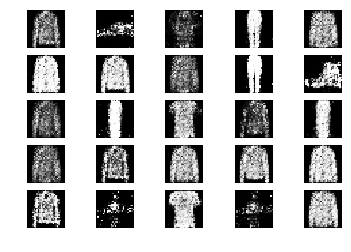

8601 [D loss: 0.660234, acc.: 59.38%] [G loss: 0.879744]
8602 [D loss: 0.692004, acc.: 54.69%] [G loss: 0.835918]
8603 [D loss: 0.658280, acc.: 57.81%] [G loss: 0.899565]
8604 [D loss: 0.707363, acc.: 53.12%] [G loss: 0.888107]
8605 [D loss: 0.629363, acc.: 60.94%] [G loss: 0.860383]
8606 [D loss: 0.649984, acc.: 62.50%] [G loss: 0.860948]
8607 [D loss: 0.707048, acc.: 54.69%] [G loss: 0.837238]
8608 [D loss: 0.690266, acc.: 56.25%] [G loss: 0.826465]
8609 [D loss: 0.639281, acc.: 64.06%] [G loss: 0.812742]
8610 [D loss: 0.652780, acc.: 57.81%] [G loss: 0.748873]
8611 [D loss: 0.688195, acc.: 46.88%] [G loss: 0.815274]
8612 [D loss: 0.707128, acc.: 46.88%] [G loss: 0.841575]
8613 [D loss: 0.622273, acc.: 73.44%] [G loss: 0.852578]
8614 [D loss: 0.702858, acc.: 51.56%] [G loss: 0.915743]
8615 [D loss: 0.682651, acc.: 51.56%] [G loss: 0.888439]
8616 [D loss: 0.617511, acc.: 65.62%] [G loss: 0.808211]
8617 [D loss: 0.748243, acc.: 48.44%] [G loss: 0.793836]
8618 [D loss: 0.677850, acc.: 5

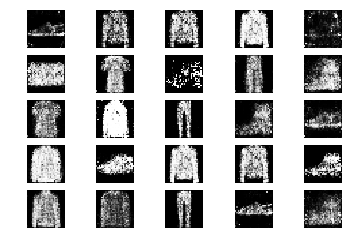

8701 [D loss: 0.728845, acc.: 51.56%] [G loss: 0.922557]
8702 [D loss: 0.643227, acc.: 53.12%] [G loss: 0.793139]
8703 [D loss: 0.685260, acc.: 53.12%] [G loss: 0.890984]
8704 [D loss: 0.641429, acc.: 65.62%] [G loss: 0.899562]
8705 [D loss: 0.664366, acc.: 59.38%] [G loss: 0.939157]
8706 [D loss: 0.651455, acc.: 57.81%] [G loss: 0.974118]
8707 [D loss: 0.681751, acc.: 53.12%] [G loss: 0.932446]
8708 [D loss: 0.665336, acc.: 53.12%] [G loss: 0.913048]
8709 [D loss: 0.649414, acc.: 53.12%] [G loss: 0.955284]
8710 [D loss: 0.685555, acc.: 48.44%] [G loss: 0.827407]
8711 [D loss: 0.633865, acc.: 59.38%] [G loss: 0.928678]
8712 [D loss: 0.703287, acc.: 46.88%] [G loss: 0.864267]
8713 [D loss: 0.693178, acc.: 53.12%] [G loss: 0.852869]
8714 [D loss: 0.700127, acc.: 56.25%] [G loss: 0.912305]
8715 [D loss: 0.666207, acc.: 54.69%] [G loss: 0.899811]
8716 [D loss: 0.686190, acc.: 62.50%] [G loss: 0.878871]
8717 [D loss: 0.690602, acc.: 56.25%] [G loss: 0.868431]
8718 [D loss: 0.710149, acc.: 5

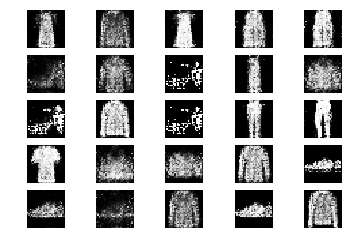

8801 [D loss: 0.637972, acc.: 62.50%] [G loss: 0.777172]
8802 [D loss: 0.739728, acc.: 51.56%] [G loss: 0.818106]
8803 [D loss: 0.677881, acc.: 60.94%] [G loss: 0.821724]
8804 [D loss: 0.670633, acc.: 59.38%] [G loss: 0.883714]
8805 [D loss: 0.631661, acc.: 65.62%] [G loss: 0.857475]
8806 [D loss: 0.661207, acc.: 53.12%] [G loss: 0.926418]
8807 [D loss: 0.672148, acc.: 57.81%] [G loss: 0.885961]
8808 [D loss: 0.702555, acc.: 45.31%] [G loss: 0.799665]
8809 [D loss: 0.674854, acc.: 48.44%] [G loss: 0.931870]
8810 [D loss: 0.670450, acc.: 57.81%] [G loss: 0.864168]
8811 [D loss: 0.641774, acc.: 60.94%] [G loss: 0.864975]
8812 [D loss: 0.685883, acc.: 59.38%] [G loss: 0.794682]
8813 [D loss: 0.699885, acc.: 48.44%] [G loss: 0.881406]
8814 [D loss: 0.703464, acc.: 48.44%] [G loss: 0.889971]
8815 [D loss: 0.661892, acc.: 57.81%] [G loss: 0.836107]
8816 [D loss: 0.726085, acc.: 39.06%] [G loss: 0.865151]
8817 [D loss: 0.672227, acc.: 59.38%] [G loss: 0.814419]
8818 [D loss: 0.713732, acc.: 4

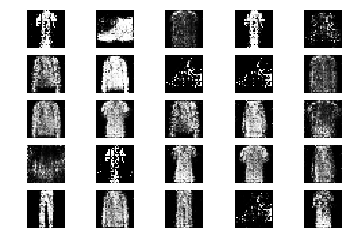

8901 [D loss: 0.703270, acc.: 45.31%] [G loss: 0.854338]
8902 [D loss: 0.695844, acc.: 56.25%] [G loss: 0.845520]
8903 [D loss: 0.696991, acc.: 54.69%] [G loss: 0.827263]
8904 [D loss: 0.688119, acc.: 60.94%] [G loss: 0.817619]
8905 [D loss: 0.706521, acc.: 56.25%] [G loss: 0.900175]
8906 [D loss: 0.682103, acc.: 51.56%] [G loss: 0.871364]
8907 [D loss: 0.672777, acc.: 54.69%] [G loss: 0.869176]
8908 [D loss: 0.665690, acc.: 62.50%] [G loss: 0.906641]
8909 [D loss: 0.705815, acc.: 51.56%] [G loss: 0.873909]
8910 [D loss: 0.746644, acc.: 46.88%] [G loss: 0.879278]
8911 [D loss: 0.697993, acc.: 56.25%] [G loss: 0.885718]
8912 [D loss: 0.656596, acc.: 59.38%] [G loss: 0.846341]
8913 [D loss: 0.680910, acc.: 54.69%] [G loss: 0.832575]
8914 [D loss: 0.651908, acc.: 57.81%] [G loss: 0.801630]
8915 [D loss: 0.686809, acc.: 51.56%] [G loss: 0.868910]
8916 [D loss: 0.640656, acc.: 67.19%] [G loss: 0.863436]
8917 [D loss: 0.637183, acc.: 60.94%] [G loss: 0.890196]
8918 [D loss: 0.696356, acc.: 4

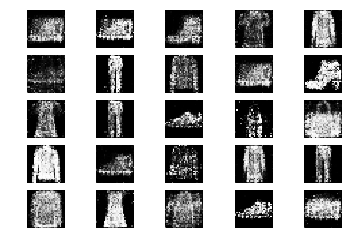

9001 [D loss: 0.668166, acc.: 54.69%] [G loss: 0.926500]
9002 [D loss: 0.695384, acc.: 60.94%] [G loss: 0.889311]
9003 [D loss: 0.722507, acc.: 50.00%] [G loss: 0.827914]
9004 [D loss: 0.640219, acc.: 64.06%] [G loss: 0.904495]
9005 [D loss: 0.649511, acc.: 67.19%] [G loss: 0.921970]
9006 [D loss: 0.705695, acc.: 43.75%] [G loss: 0.940452]
9007 [D loss: 0.664945, acc.: 60.94%] [G loss: 0.934575]
9008 [D loss: 0.722240, acc.: 45.31%] [G loss: 0.924915]
9009 [D loss: 0.679474, acc.: 54.69%] [G loss: 0.880217]
9010 [D loss: 0.652327, acc.: 60.94%] [G loss: 0.890084]
9011 [D loss: 0.706051, acc.: 54.69%] [G loss: 0.876372]
9012 [D loss: 0.697535, acc.: 51.56%] [G loss: 0.871652]
9013 [D loss: 0.630859, acc.: 60.94%] [G loss: 0.901780]
9014 [D loss: 0.640697, acc.: 62.50%] [G loss: 0.934351]
9015 [D loss: 0.659539, acc.: 59.38%] [G loss: 0.859132]
9016 [D loss: 0.671884, acc.: 59.38%] [G loss: 0.864272]
9017 [D loss: 0.708235, acc.: 57.81%] [G loss: 0.820901]
9018 [D loss: 0.646287, acc.: 6

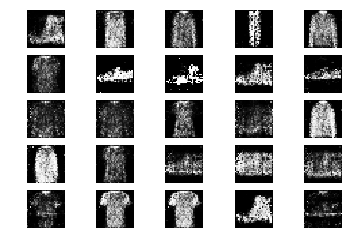

9101 [D loss: 0.675905, acc.: 57.81%] [G loss: 0.818106]
9102 [D loss: 0.683321, acc.: 54.69%] [G loss: 0.858341]
9103 [D loss: 0.688143, acc.: 46.88%] [G loss: 0.939918]
9104 [D loss: 0.690729, acc.: 54.69%] [G loss: 0.858615]
9105 [D loss: 0.705691, acc.: 51.56%] [G loss: 0.868384]
9106 [D loss: 0.680139, acc.: 56.25%] [G loss: 0.828410]
9107 [D loss: 0.673350, acc.: 48.44%] [G loss: 0.853993]
9108 [D loss: 0.628806, acc.: 60.94%] [G loss: 0.796225]
9109 [D loss: 0.699925, acc.: 45.31%] [G loss: 0.827949]
9110 [D loss: 0.708609, acc.: 48.44%] [G loss: 0.819311]
9111 [D loss: 0.680231, acc.: 48.44%] [G loss: 0.797891]
9112 [D loss: 0.677160, acc.: 54.69%] [G loss: 0.835838]
9113 [D loss: 0.709304, acc.: 48.44%] [G loss: 0.847824]
9114 [D loss: 0.650554, acc.: 67.19%] [G loss: 0.821022]
9115 [D loss: 0.698602, acc.: 53.12%] [G loss: 0.803944]
9116 [D loss: 0.692537, acc.: 50.00%] [G loss: 0.777114]
9117 [D loss: 0.654499, acc.: 62.50%] [G loss: 0.850709]
9118 [D loss: 0.649343, acc.: 5

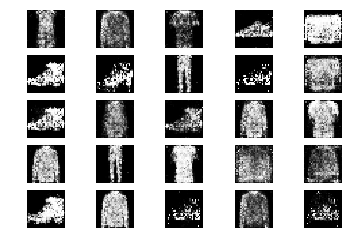

9201 [D loss: 0.645420, acc.: 62.50%] [G loss: 0.848917]
9202 [D loss: 0.666631, acc.: 59.38%] [G loss: 0.791481]
9203 [D loss: 0.660937, acc.: 59.38%] [G loss: 0.833220]
9204 [D loss: 0.626484, acc.: 60.94%] [G loss: 0.841078]
9205 [D loss: 0.616138, acc.: 62.50%] [G loss: 0.838239]
9206 [D loss: 0.600885, acc.: 67.19%] [G loss: 0.877146]
9207 [D loss: 0.697507, acc.: 51.56%] [G loss: 0.872025]
9208 [D loss: 0.677072, acc.: 54.69%] [G loss: 0.816649]
9209 [D loss: 0.675391, acc.: 56.25%] [G loss: 0.899037]
9210 [D loss: 0.713563, acc.: 48.44%] [G loss: 0.862721]
9211 [D loss: 0.712734, acc.: 53.12%] [G loss: 0.849956]
9212 [D loss: 0.677676, acc.: 50.00%] [G loss: 0.837851]
9213 [D loss: 0.730389, acc.: 37.50%] [G loss: 0.791146]
9214 [D loss: 0.641067, acc.: 68.75%] [G loss: 0.888723]
9215 [D loss: 0.633101, acc.: 67.19%] [G loss: 0.869450]
9216 [D loss: 0.716465, acc.: 48.44%] [G loss: 0.875191]
9217 [D loss: 0.673258, acc.: 53.12%] [G loss: 0.910221]
9218 [D loss: 0.678757, acc.: 5

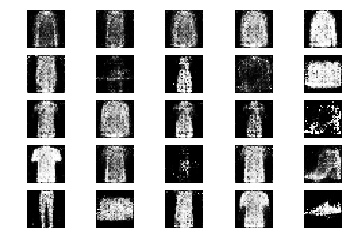

9301 [D loss: 0.728281, acc.: 46.88%] [G loss: 0.807313]
9302 [D loss: 0.671919, acc.: 56.25%] [G loss: 0.789635]
9303 [D loss: 0.727742, acc.: 56.25%] [G loss: 0.808338]
9304 [D loss: 0.738370, acc.: 45.31%] [G loss: 0.843536]
9305 [D loss: 0.673445, acc.: 62.50%] [G loss: 0.847000]
9306 [D loss: 0.706105, acc.: 53.12%] [G loss: 0.881273]
9307 [D loss: 0.667620, acc.: 57.81%] [G loss: 0.864804]
9308 [D loss: 0.681624, acc.: 59.38%] [G loss: 0.886631]
9309 [D loss: 0.699650, acc.: 53.12%] [G loss: 0.839829]
9310 [D loss: 0.673928, acc.: 56.25%] [G loss: 0.827818]
9311 [D loss: 0.663815, acc.: 53.12%] [G loss: 0.907087]
9312 [D loss: 0.680293, acc.: 56.25%] [G loss: 0.817336]
9313 [D loss: 0.669948, acc.: 62.50%] [G loss: 0.831500]
9314 [D loss: 0.663564, acc.: 57.81%] [G loss: 0.813980]
9315 [D loss: 0.642898, acc.: 59.38%] [G loss: 0.848129]
9316 [D loss: 0.638248, acc.: 62.50%] [G loss: 0.865209]
9317 [D loss: 0.689988, acc.: 51.56%] [G loss: 0.868636]
9318 [D loss: 0.641952, acc.: 6

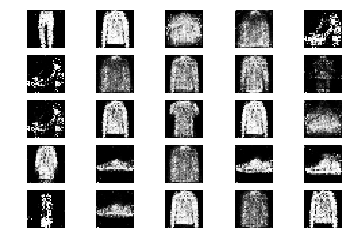

9401 [D loss: 0.697525, acc.: 50.00%] [G loss: 0.837853]
9402 [D loss: 0.753856, acc.: 46.88%] [G loss: 0.811979]
9403 [D loss: 0.658420, acc.: 56.25%] [G loss: 0.819186]
9404 [D loss: 0.639202, acc.: 67.19%] [G loss: 0.876236]
9405 [D loss: 0.724242, acc.: 45.31%] [G loss: 0.895743]
9406 [D loss: 0.652358, acc.: 59.38%] [G loss: 0.853540]
9407 [D loss: 0.601497, acc.: 67.19%] [G loss: 0.823816]
9408 [D loss: 0.618406, acc.: 68.75%] [G loss: 0.887540]
9409 [D loss: 0.655232, acc.: 56.25%] [G loss: 0.849200]
9410 [D loss: 0.565550, acc.: 70.31%] [G loss: 0.877705]
9411 [D loss: 0.615180, acc.: 64.06%] [G loss: 0.854505]
9412 [D loss: 0.719010, acc.: 51.56%] [G loss: 0.847958]
9413 [D loss: 0.680583, acc.: 54.69%] [G loss: 0.878688]
9414 [D loss: 0.705011, acc.: 59.38%] [G loss: 0.866686]
9415 [D loss: 0.675782, acc.: 54.69%] [G loss: 0.854762]
9416 [D loss: 0.691762, acc.: 56.25%] [G loss: 0.829316]
9417 [D loss: 0.642772, acc.: 64.06%] [G loss: 0.850379]
9418 [D loss: 0.727708, acc.: 4

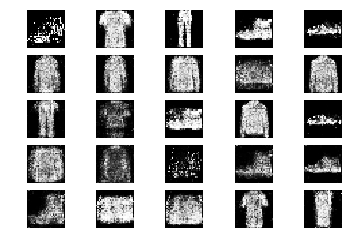

9501 [D loss: 0.668787, acc.: 53.12%] [G loss: 0.872506]
9502 [D loss: 0.616981, acc.: 71.88%] [G loss: 0.781576]
9503 [D loss: 0.629544, acc.: 59.38%] [G loss: 0.879553]
9504 [D loss: 0.667126, acc.: 57.81%] [G loss: 0.864161]
9505 [D loss: 0.680248, acc.: 48.44%] [G loss: 0.874996]
9506 [D loss: 0.690119, acc.: 50.00%] [G loss: 0.782906]
9507 [D loss: 0.703946, acc.: 53.12%] [G loss: 0.790274]
9508 [D loss: 0.640475, acc.: 62.50%] [G loss: 0.781087]
9509 [D loss: 0.678360, acc.: 48.44%] [G loss: 0.815870]
9510 [D loss: 0.653399, acc.: 60.94%] [G loss: 0.815895]
9511 [D loss: 0.662433, acc.: 57.81%] [G loss: 0.825719]
9512 [D loss: 0.720737, acc.: 43.75%] [G loss: 0.829114]
9513 [D loss: 0.658641, acc.: 56.25%] [G loss: 0.896929]
9514 [D loss: 0.660040, acc.: 57.81%] [G loss: 0.873087]
9515 [D loss: 0.646920, acc.: 60.94%] [G loss: 0.864941]
9516 [D loss: 0.636016, acc.: 60.94%] [G loss: 0.962226]
9517 [D loss: 0.645161, acc.: 56.25%] [G loss: 0.924545]
9518 [D loss: 0.674230, acc.: 5

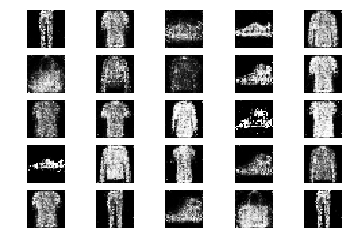

9601 [D loss: 0.655718, acc.: 60.94%] [G loss: 0.791512]
9602 [D loss: 0.708292, acc.: 48.44%] [G loss: 0.817638]
9603 [D loss: 0.699655, acc.: 56.25%] [G loss: 0.789102]
9604 [D loss: 0.723801, acc.: 51.56%] [G loss: 0.813999]
9605 [D loss: 0.672373, acc.: 56.25%] [G loss: 0.836262]
9606 [D loss: 0.654950, acc.: 62.50%] [G loss: 0.826977]
9607 [D loss: 0.703376, acc.: 51.56%] [G loss: 0.818478]
9608 [D loss: 0.690800, acc.: 53.12%] [G loss: 0.844891]
9609 [D loss: 0.677219, acc.: 51.56%] [G loss: 0.806348]
9610 [D loss: 0.700709, acc.: 46.88%] [G loss: 0.884424]
9611 [D loss: 0.715738, acc.: 46.88%] [G loss: 0.815777]
9612 [D loss: 0.677645, acc.: 51.56%] [G loss: 0.827501]
9613 [D loss: 0.683505, acc.: 50.00%] [G loss: 0.840611]
9614 [D loss: 0.709666, acc.: 48.44%] [G loss: 0.831315]
9615 [D loss: 0.672850, acc.: 54.69%] [G loss: 0.940535]
9616 [D loss: 0.758560, acc.: 32.81%] [G loss: 0.863484]
9617 [D loss: 0.704066, acc.: 53.12%] [G loss: 0.832961]
9618 [D loss: 0.666206, acc.: 6

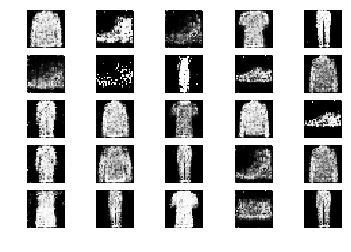

9701 [D loss: 0.706017, acc.: 54.69%] [G loss: 0.869002]
9702 [D loss: 0.672329, acc.: 56.25%] [G loss: 0.881484]
9703 [D loss: 0.631350, acc.: 67.19%] [G loss: 0.861843]
9704 [D loss: 0.707029, acc.: 62.50%] [G loss: 0.877716]
9705 [D loss: 0.672397, acc.: 59.38%] [G loss: 0.892988]
9706 [D loss: 0.654687, acc.: 60.94%] [G loss: 0.804222]
9707 [D loss: 0.702060, acc.: 56.25%] [G loss: 0.880871]
9708 [D loss: 0.632343, acc.: 68.75%] [G loss: 0.843294]
9709 [D loss: 0.664299, acc.: 59.38%] [G loss: 0.834158]
9710 [D loss: 0.685390, acc.: 51.56%] [G loss: 0.862925]
9711 [D loss: 0.661432, acc.: 60.94%] [G loss: 0.842366]
9712 [D loss: 0.700830, acc.: 50.00%] [G loss: 0.856268]
9713 [D loss: 0.733913, acc.: 43.75%] [G loss: 0.850833]
9714 [D loss: 0.647054, acc.: 65.62%] [G loss: 0.874896]
9715 [D loss: 0.682579, acc.: 53.12%] [G loss: 0.874001]
9716 [D loss: 0.690908, acc.: 50.00%] [G loss: 0.831987]
9717 [D loss: 0.666263, acc.: 54.69%] [G loss: 0.928124]
9718 [D loss: 0.645759, acc.: 6

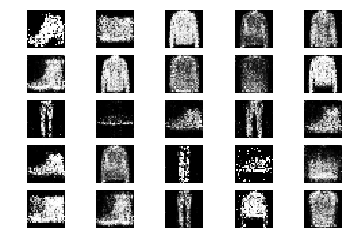

9801 [D loss: 0.661450, acc.: 60.94%] [G loss: 0.815089]
9802 [D loss: 0.647579, acc.: 65.62%] [G loss: 0.876811]
9803 [D loss: 0.658422, acc.: 60.94%] [G loss: 0.901480]
9804 [D loss: 0.635074, acc.: 64.06%] [G loss: 0.915049]
9805 [D loss: 0.652534, acc.: 60.94%] [G loss: 0.837662]
9806 [D loss: 0.655114, acc.: 60.94%] [G loss: 0.878429]
9807 [D loss: 0.706918, acc.: 51.56%] [G loss: 0.847639]
9808 [D loss: 0.676299, acc.: 56.25%] [G loss: 0.835780]
9809 [D loss: 0.672916, acc.: 56.25%] [G loss: 0.862939]
9810 [D loss: 0.655615, acc.: 60.94%] [G loss: 0.857116]
9811 [D loss: 0.664377, acc.: 59.38%] [G loss: 0.808480]
9812 [D loss: 0.639116, acc.: 64.06%] [G loss: 0.844647]
9813 [D loss: 0.689138, acc.: 51.56%] [G loss: 0.880416]
9814 [D loss: 0.593084, acc.: 75.00%] [G loss: 0.941894]
9815 [D loss: 0.649473, acc.: 59.38%] [G loss: 0.929920]
9816 [D loss: 0.622743, acc.: 67.19%] [G loss: 0.942772]
9817 [D loss: 0.769232, acc.: 51.56%] [G loss: 0.818955]
9818 [D loss: 0.679620, acc.: 7

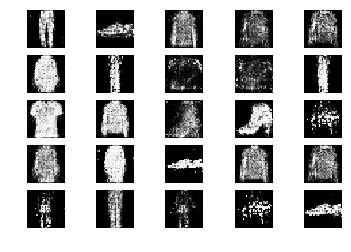

9901 [D loss: 0.619323, acc.: 62.50%] [G loss: 0.911519]
9902 [D loss: 0.669911, acc.: 53.12%] [G loss: 0.862839]
9903 [D loss: 0.631861, acc.: 57.81%] [G loss: 0.829882]
9904 [D loss: 0.724171, acc.: 48.44%] [G loss: 0.828352]
9905 [D loss: 0.650132, acc.: 59.38%] [G loss: 0.828902]
9906 [D loss: 0.661709, acc.: 60.94%] [G loss: 0.838899]
9907 [D loss: 0.664350, acc.: 59.38%] [G loss: 0.744869]
9908 [D loss: 0.674409, acc.: 54.69%] [G loss: 0.836784]
9909 [D loss: 0.666855, acc.: 62.50%] [G loss: 0.858544]
9910 [D loss: 0.664572, acc.: 62.50%] [G loss: 0.829234]
9911 [D loss: 0.699041, acc.: 56.25%] [G loss: 0.872242]
9912 [D loss: 0.648740, acc.: 67.19%] [G loss: 0.868956]
9913 [D loss: 0.673477, acc.: 56.25%] [G loss: 0.919183]
9914 [D loss: 0.654627, acc.: 59.38%] [G loss: 0.864134]
9915 [D loss: 0.724446, acc.: 40.62%] [G loss: 0.905307]
9916 [D loss: 0.727679, acc.: 48.44%] [G loss: 0.863505]
9917 [D loss: 0.629768, acc.: 68.75%] [G loss: 0.829740]
9918 [D loss: 0.636285, acc.: 6

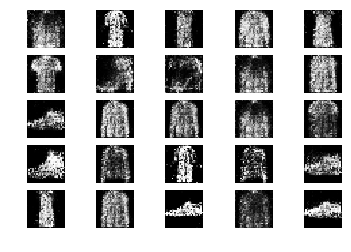

In [6]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=10001, batch_size=32, sample_interval=100)